# Volcanic Forcing Statistical Analysis - Figure 1

This notebook performs statistical analysis of volcanic forcing records to characterize the distribution of volcanic eruption magnitudes. The analysis combines data from two key sources and fits Generalized Extreme Value (GEV) distributions to understand volcanic forcing statistics.

## Data Sources

**1. Lin et al. MIS3 Data (Marine Isotope Stage 3, ~60-24 kyr BP):**
- Ice core-based volcanic sulfate deposition record
- Covers the last glacial period when Dansgaard-Oeschger (D-O) events occurred
- Provides eruption magnitude (stratospheric sulfate loading in Tg SO₄)
- Source location classified as: Northern Hemisphere (NH), Equatorial (EQ), Southern Hemisphere (SH)

**2. Sigl et al. 2022 Holocene Volcanic Dataset (HolVol):**
- Comprehensive volcanic forcing reconstruction for the Holocene (~12 kyr BP to present)
- Volcanic Stratospheric Sulfur Injection (VSSI) estimates
- Georeferenced eruption locations (latitude/longitude)

## Analysis Workflow

1. **Data Loading and Preparation:**
   - Load Lin et al. MIS3 volcanic record from Excel spreadsheet
   - Load Sigl et al. 2022 HolVol dataset from NetCDF
   - Load NGRIP temperature reconstruction (Pedro et al. 2018) for climate context

2. **Data Binning and Resampling:**
   - Divide MIS3 time period into equal-duration bins
   - Extract maximum volcanic load in each bin
   - Creates evenly-sampled dataset suitable for statistical analysis

3. **Statistical Distribution Fitting:**
   - Fit Generalized Extreme Value (GEV) distribution to volcanic loading data
   - GEV distribution characterizes extreme events (large eruptions)
   - Extract shape, location, and scale parameters for both datasets

4. **Visualization:**
   - Time series of volcanic events by hemisphere
   - Histograms of volcanic loading magnitudes
   - GEV probability density functions overlaid on histograms

## Key Outputs

- **GEV Parameters:** Shape (ξ), location (μ), and scale (σ) parameters characterizing volcanic forcing statistics
- **Figure 1 Components:** Visual comparison of Lin (MIS3) and Sigl (Holocene) volcanic forcing distributions
- **Statistical Foundation:** These parameters are used to generate synthetic volcanic forcing scenarios for climate model experiments

## Scientific Context

Understanding the statistical distribution of volcanic eruption magnitudes is essential for:
- Generating realistic synthetic volcanic forcing scenarios
- Assessing probability of extreme volcanic events
- Comparing glacial (MIS3) vs. interglacial (Holocene) volcanic activity

In [1]:
# numpy/scipy stuff
import numpy as np
import numpy.ma as ma

from scipy.signal import argrelextrema
from scipy.stats import genextreme as gev

from netCDF4 import Dataset 

# matplotlib stuff
import matplotlib.pyplot as plt
#plt.style.use('seaborn-talk')
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

# data sci stuff
import xarray as xr
import pandas as pd

# system stuff
import os
import sys
import glob
import fnmatch

# netcdf stuff
from netCDF4 import Dataset
import datetime
import cftime
import nc_time_axis

# widgets stuff
import ipywidgets as widgets
from ipywidgets import interact,interactive
import xlrd


In [2]:
print("numpy version: ", np.__version__)
print("matplotlib version: ", mpl.__version__)
print("xarray version: ", xr.__version__)
print("pandas version: ", pd.__version__)


numpy version:  2.2.6
matplotlib version:  3.10.3
xarray version:  2025.11.0
pandas version:  2.2.3


In [3]:
def setaxesfsize(axl,fontsize, xlabel, ylabel, labsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
#    i=0
    for labely in ticklabelleft:
#        if i != 0:
            labely.set_fontsize(fontsize)
    
    axl.set_xlabel(xlabel, size=labsize)
    axl.set_ylabel(ylabel, size=labsize)

In [4]:
ngrip_t_pedro_2018 = pd.read_csv("/scratch/Dropbox/ipynb/D-O_analysis/volcanic/Pedro_QSR2018_fig1a.txt", sep='\t', names=["Year", "Temperature"])

ngrip_t_pedro_2018

,Year,Temperature
0,20000,-45.005556
1,20020,-44.984211
2,20040,-44.916000
3,20060,-44.812000
4,20080,-44.678000
...,...,...
2246,64920,-48.824286
2247,64940,-48.369000
2248,64960,-48.107000
2249,64980,-48.131053


In [5]:
sigl2022 = xr.open_dataset("/scratch/Dropbox/ipynb/D-O_analysis/volcanic/HolVol_volcanic_stratospheric_sulfur_injection_v1.0.nc", engine='netcdf4')

In [6]:
sigl2022

<xarray.Dataset> Size: 100kB
Dimensions:     (nerup: 1384)
Dimensions without coordinates: nerup
Data variables:
    year        (nerup) float64 11kB ...
    yearCE      (nerup) float64 11kB ...
    month       (nerup) float64 11kB ...
    day         (nerup) float64 11kB ...
    lat         (nerup) float64 11kB ...
    vssi        (nerup) float64 11kB ...
    hemi        (nerup) float64 11kB ...
    sigma_vssi  (nerup) float64 11kB ...
    duration    (nerup) float64 11kB ...
Attributes:
    title:    Ice core-inferred volcanic stratospheric sulfur injection for t...
    history:  Created Tue Jun  9 23:01:18 2020
    source:   Sigl et al., in preparation

In [7]:
# load the Jai-Mei's data
lin_volc_data = pd.ExcelFile("/scratch/Dropbox/ipynb/D-O_analysis/volcanic/Lin_MIS3_volcanic_supp.xls")


In [8]:
lin_load_data = lin_volc_data.parse('Table S5', header=1)

In [9]:
gicc05_age = lin_load_data[lin_load_data.columns[1]].copy()
volc_load = lin_load_data[lin_load_data.columns[26]].copy()
site_loc = lin_load_data[lin_load_data.columns[31]].copy()

In [10]:
# Fix 2 southern hemisphere eruptions that we know were in the Southern Hemisphere


site_loc[21] = "SH"
site_loc[62] = "SH"


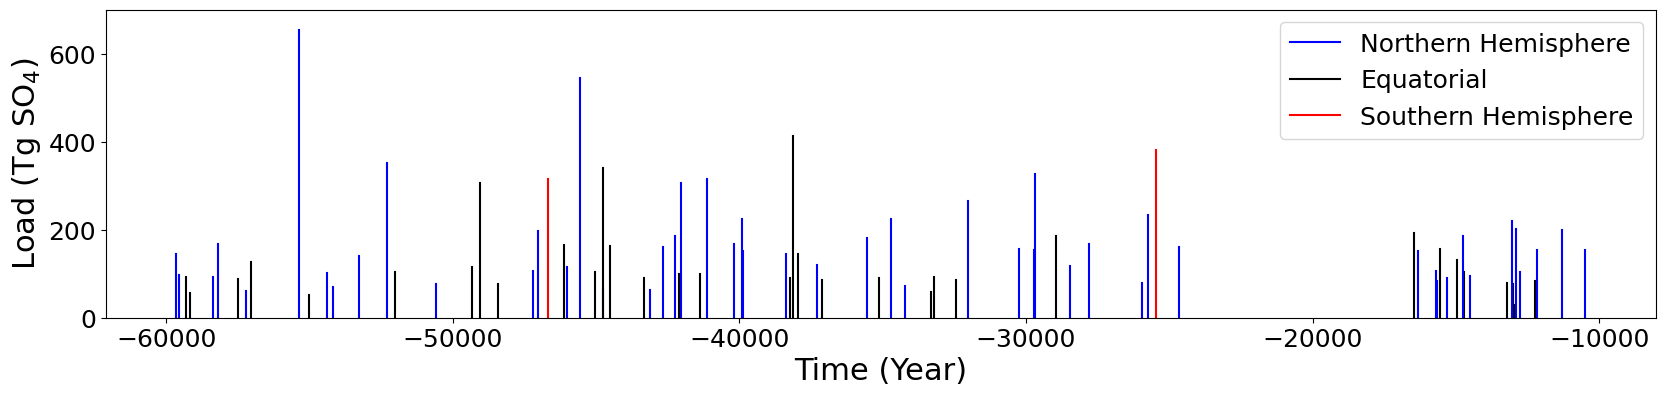

In [11]:

# plot chronologies

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 25
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
#
eleg=True
nleg=True
sleg=True

for e in range(len(gicc05_age)):
    if site_loc[e] == "NHHL":
        if nleg:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='b', label="Northern Hemisphere")
            nleg=False
        else:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='b')
    elif site_loc[e] == "LL or SH":
        if eleg:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='k', label="Equatorial")
            eleg=False
        else:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='k')
    elif site_loc[e] == "SH":
        if sleg:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='r', label="Southern Hemisphere")
            sleg=False
        else:
            ax.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='r')
#ax.set_xlim(-60000, -24000) 
#ax.set_xlim(-60000, 0) 
ax.set_ylabel("Load (Tg SO$_4$)")
#ax.set_ylim(0,180)
ax.set_xlabel('Time (Year)')
#axes[axId].set_ylabel('Load (Tg)')
#ax.set_yticks([0,25,50,75,100,125,150,175])
ax.set_ylim(0,700)
ax.legend()

icepaperdir="/home/guido/Dropbox/plots/volcanic/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"random_mis3volc_plus_Lin_large.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
    plt.savefig(icepaperdir+"random_mis3volc_plus_Lin_large.pdf", dpi=300, facecolor=fig.get_facecolor(), transparent=True)

In [12]:
## I want to resample the data so that we take maxima and bin them into even time sections
mis3age = gicc05_age[20:]
mis3load = volc_load[20:]

In [13]:
mis3load.index.values


array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

In [14]:

# Your actual data (this is just a placeholder for illustration, replace it with your actual dataset)
time_series = mis3age

load_series = mis3load

# Convert the time_series and load_series into a DataFrame
df = pd.DataFrame({'Time': time_series, 'Load': load_series})

# Define custom bin edges based on time_series values
# You can use a fixed number of bins or custom breakpoints.
# Here, we use 5 bins for illustration
num_bins = 23 # adjust higher until there are no more nan's
bins = pd.cut(df['Time'], bins=num_bins)

# Add the bin information to the DataFrame
df['Bin'] = bins

# Group by the 'Bin' and calculate the maximum 'Load' in each bin
rebinned_df = df.groupby('Bin').agg(MaxLoad=('Load', 'max'))

# Extract the bin edges (lower and upper bounds)
rebinned_df['BinStart'] = rebinned_df.index.categories.left
rebinned_df['BinEnd'] = rebinned_df.index.categories.right

# Calculate the delta time for each bin
rebinned_df['DeltaTime'] = rebinned_df['BinEnd'] - rebinned_df['BinStart']

# Calculate the middle of the bin (BinMid)
rebinned_df['BinMid'] = (rebinned_df['BinStart'] + rebinned_df['BinEnd']) / 2

# Reorder the columns
rebinned_df = rebinned_df[['BinStart', 'BinEnd', 'BinMid', 'DeltaTime', 'MaxLoad']]

# Output the rebinned dataset
print(rebinned_df)


                         BinStart     BinEnd      BinMid  DeltaTime  \
Bin                                                                   
(24633.918, 26189.701]  24633.918  26189.701  25411.8095   1555.783   
(26189.701, 27710.506]  26189.701  27710.506  26950.1035   1520.805   
(27710.506, 29231.31]   27710.506  29231.310  28470.9080   1520.804   
(29231.31, 30752.115]   29231.310  30752.115  29991.7125   1520.805   
(30752.115, 32272.919]  30752.115  32272.919  31512.5170   1520.804   
(32272.919, 33793.724]  32272.919  33793.724  33033.3215   1520.805   
(33793.724, 35314.528]  33793.724  35314.528  34554.1260   1520.804   
(35314.528, 36835.333]  35314.528  36835.333  36074.9305   1520.805   
(36835.333, 38356.137]  36835.333  38356.137  37595.7350   1520.804   
(38356.137, 39876.942]  38356.137  39876.942  39116.5395   1520.805   
(39876.942, 41397.746]  39876.942  41397.746  40637.3440   1520.804   
(41397.746, 42918.551]  41397.746  42918.551  42158.1485   1520.805   
(42918

/tmp/ipykernel_287523/3024582526.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rebinned_df = df.groupby('Bin').agg(MaxLoad=('Load', 'max'))


In [15]:
# only take the data from the nan onwards
lin_new_df = rebinned_df[2:]

In [16]:
print(lin_new_df)

                         BinStart     BinEnd      BinMid  DeltaTime  \
Bin                                                                   
(27710.506, 29231.31]   27710.506  29231.310  28470.9080   1520.804   
(29231.31, 30752.115]   29231.310  30752.115  29991.7125   1520.805   
(30752.115, 32272.919]  30752.115  32272.919  31512.5170   1520.804   
(32272.919, 33793.724]  32272.919  33793.724  33033.3215   1520.805   
(33793.724, 35314.528]  33793.724  35314.528  34554.1260   1520.804   
(35314.528, 36835.333]  35314.528  36835.333  36074.9305   1520.805   
(36835.333, 38356.137]  36835.333  38356.137  37595.7350   1520.804   
(38356.137, 39876.942]  38356.137  39876.942  39116.5395   1520.805   
(39876.942, 41397.746]  39876.942  41397.746  40637.3440   1520.804   
(41397.746, 42918.551]  41397.746  42918.551  42158.1485   1520.805   
(42918.551, 44439.355]  42918.551  44439.355  43678.9530   1520.804   
(44439.355, 45960.16]   44439.355  45960.160  45199.7575   1520.805   
(45960

In [17]:
lin_new_df["BinMid"].values

array([28470.908 , 29991.7125, 31512.517 , 33033.3215, 34554.126 ,
       36074.9305, 37595.735 , 39116.5395, 40637.344 , 42158.1485,
       43678.953 , 45199.7575, 46720.562 , 48241.3665, 49762.171 ,
       51282.9755, 52803.78  , 54324.5845, 55845.389 , 57366.1935,
       58886.998 ])

[[<matplotlib.lines.Line2D at 0x7ee80d8d5010>],

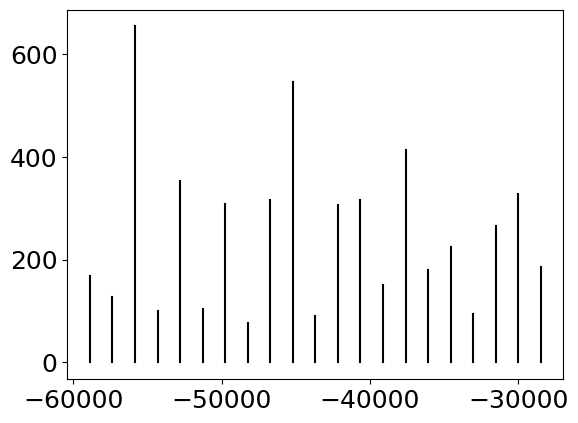

In [18]:
[ plt.plot([-lin_new_df["BinMid"].values[e],-lin_new_df["BinMid"].values[e]], [0, lin_new_df["MaxLoad"].values[e]],color='k') 
 for e in range(len(lin_new_df["BinMid"])) ]

-0.2470981072803381
171.41284059910026
97.03317998392464


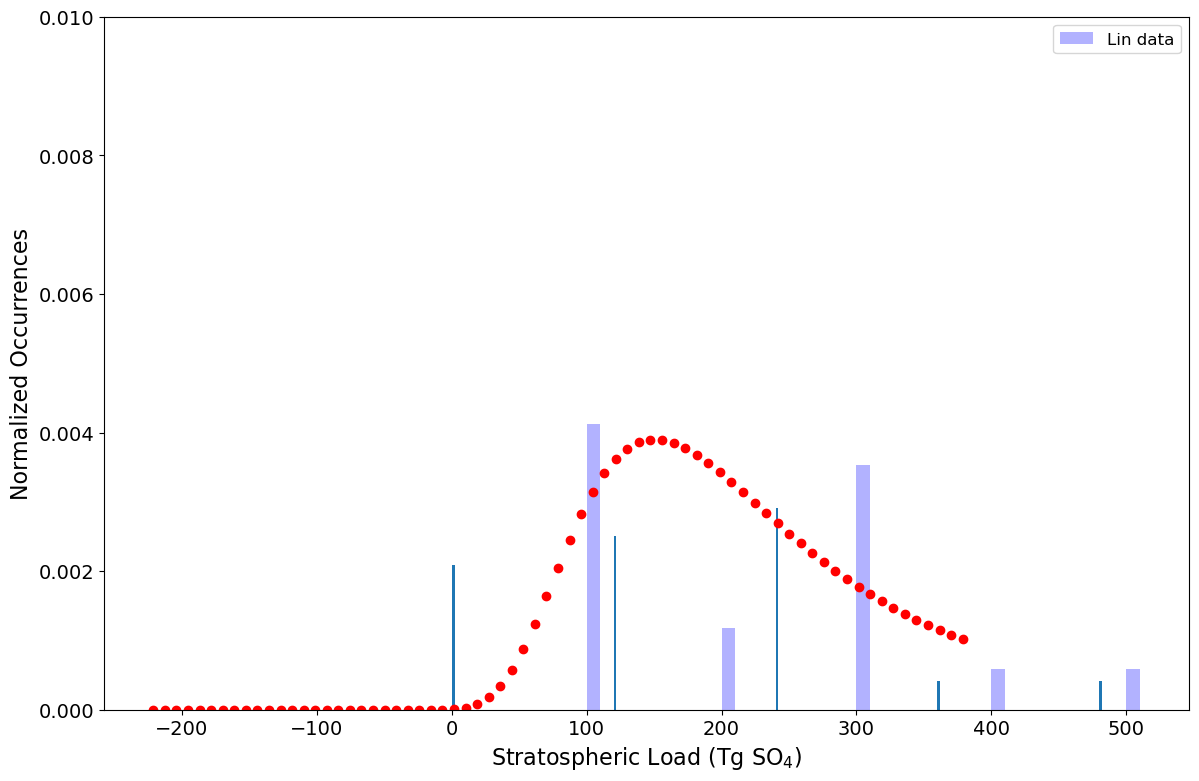

In [19]:
# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Plot histogram for Lin data
hist_lin, bins_lin = np.histogram(lin_new_df["MaxLoad"], bins=5, range=(100, 600), density=True)
ax.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="Lin data")

#ax.set_yscale('log')
ax.set_ylabel("Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Normalized Occurrences", 16)

#ax.set_title('Levy-stable distribution fit for Sigl and Lin data', size=16)
ax.set_ylim(0, 0.01)
plt.legend(fontsize=12)

def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return shape, loc, scale


shape, loc, scale = main(lin_new_df["MaxLoad"].values)

print(shape)
print(loc)
print(scale)

l = loc + scale / shape

xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)

hist, bins = np.histogram(lin_new_df["MaxLoad"].values, bins=5, range=(0, 600), density=True)
plt.bar(bins[:-1], hist, width = 2, align='edge')

plt.plot(xx, yy, 'ro')

# these are the GEV parameters for the massaged Lin data
lin_ml_loc = loc 
lin_ml_scale = scale
lin_ml_shape = shape


In [20]:
sigl_hol_volc_data = xr.open_dataset("/home/guido/Dropbox/ipynb/D-O_analysis/volcanic/HolVol_volcanic_stratospheric_sulfur_injection_v1.0.nc")

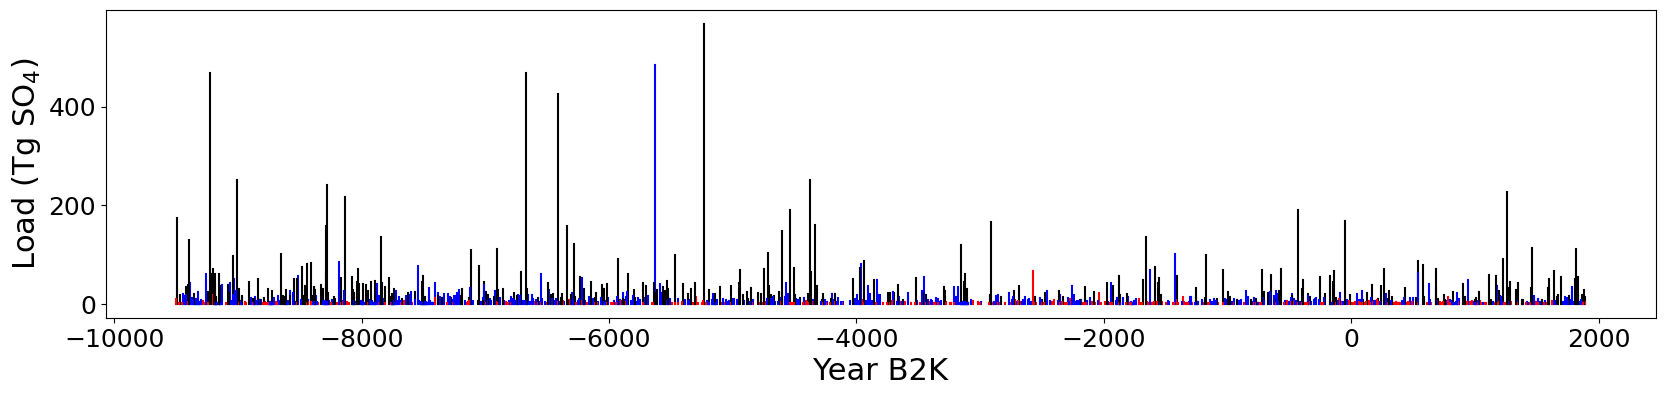

In [21]:
# plot chronologies

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 25
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
#
for e in range(len(sigl_hol_volc_data.vssi)):
    if sigl_hol_volc_data.lat[e] > 20.0:
        ax.plot([sigl_hol_volc_data.yearCE[e],sigl_hol_volc_data.yearCE[e]],[0,sigl_hol_volc_data.vssi[e]*3.0],color='b')
    elif sigl_hol_volc_data.lat[e] >= -20 and sigl_hol_volc_data.lat[e] <= 20:
        ax.plot([sigl_hol_volc_data.yearCE[e],sigl_hol_volc_data.yearCE[e]],[0,sigl_hol_volc_data.vssi[e]*3.0],color='k')
    elif sigl_hol_volc_data.lat[e] < -20.:
        ax.plot([sigl_hol_volc_data.yearCE[e],sigl_hol_volc_data.yearCE[e]],[0,sigl_hol_volc_data.vssi[e]*3.0],color='r')
#ax.set_xlim(24000,60000) 
ax.set_ylabel('Load (Tg SO$_4$)')
#ax.set_ylim(0,180)
ax.set_xlabel('Year B2K')
#axes[axId].set_ylabel('Load (Tg)')
#ax.set_yticks([0,25,50,75,100,125,150,175])


#for e in range(len(year)):
#    if flag[e] == 1:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='k')
#    elif flag[e] == 2:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='b')
#    elif flag[e] == 3:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='r')
icepaperdir="/home/guido/Dropbox/plots/volcanic/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"random_mis3volc_plus_Sigl2022.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
    plt.savefig(icepaperdir+"random_mis3volc_plus_Sigl2022.pdf", dpi=300, facecolor=fig.get_facecolor(), transparent=True)

In [22]:
sigl2022 = sigl_hol_volc_data.copy()

In [23]:
mass = sigl2022.vssi*3

In [24]:
mass.values

array([ 13.32,   3.12,  27.27, ...,  27.39, 173.7 ,   8.67], shape=(1384,))

(array([1.032e+03, 1.650e+02, 8.100e+01, 3.400e+01, 2.700e+01, 9.000e+00,
        8.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
        165., 180., 195., 210., 225., 240., 255., 270., 285., 300., 315.,
        330., 345., 360., 375., 390., 405., 420., 435., 450., 465., 480.,
        495., 510., 525., 540., 555., 570., 585., 600.]),
 <BarContainer object of 40 artists>)

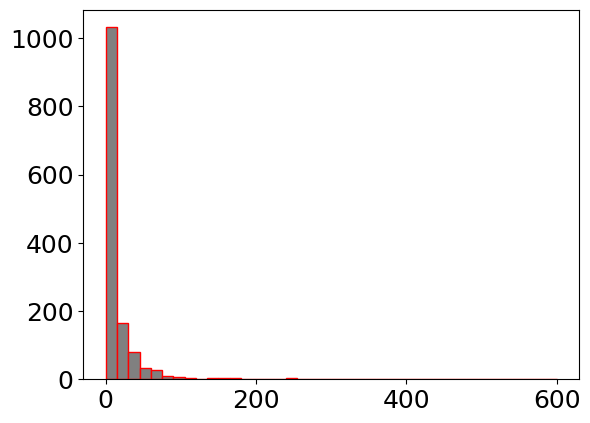

In [25]:
plt.hist(sigl2022.vssi*3, bins=np.linspace(0,600,41), edgecolor="red", color="grey")
#plt.yscale('log')

In [26]:
a=gev.fit(mass)

-0.21988720690114583
12.749730029827154
3.448963234019624


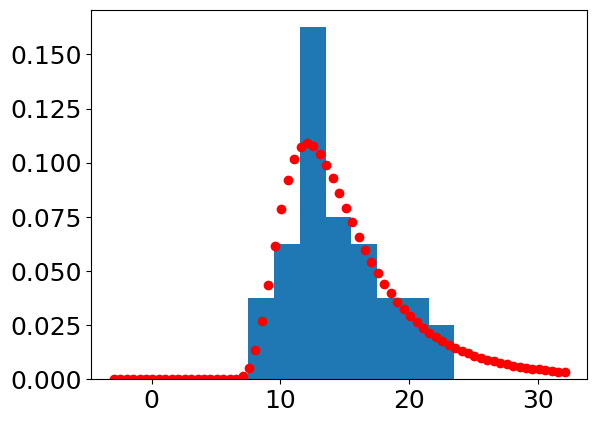

In [27]:
# gev example
def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return shape, loc, scale

rvs = [9.4, 38.0, 12.5, 35.3, 17.6, 12.9, 12.4, 19.6, 15.0, 13.2, 12.3, 16.9, 16.9, 29.4, 13.6, 11.1, 8.0, 16.6, 12.0, 13.1, 9.1, 9.7, 21.0, 11.2, 14.4, 18.8, 14.0, 19.9, 12.4, 10.8, 21.6, 15.4, 17.4, 14.8, 22.7, 11.5, 10.5, 11.8, 12.4, 16.6, 11.7, 12.9, 17.8]

shape, loc, scale = main(rvs)

print(shape)
print(loc)
print(scale)

l = loc + scale / shape

xx = np.linspace(l+0.00001, l+0.00001+35, num=71)
yy = gev.pdf(xx, shape, loc, scale)

hist, bins = np.histogram(rvs, bins=12, range=(-0.5, 23.5), density=True)
plt.bar(bins[:-1], hist, width = 2, align='edge')

plt.plot(xx, yy, 'ro')


In [28]:
len(rvs)

43

-1.344260778639558
2.498705531121373
3.163418016409622
0.1454284983635481


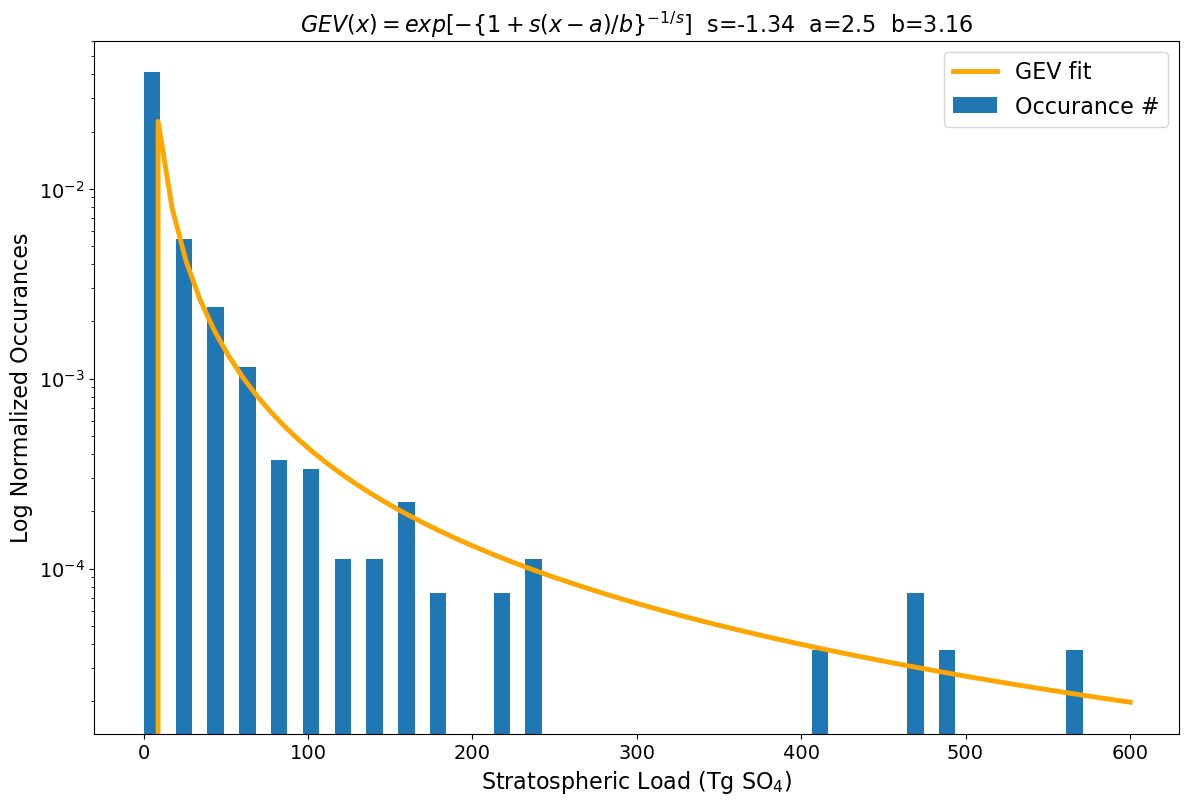

In [29]:
fig=plt.figure(figsize=(14,9))
ax = plt.subplot(111)
shape, loc, scale = gev.fit(mass)

print(shape)
print(loc)
print(scale)

l = loc + scale / shape
print (l)
xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)

hist, bins = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax.bar(bins[:-1], hist, width = 10, align='edge', label="Occurance #")

ax.plot(xx, yy, 'orange', linewidth = 3.5, label = "GEV fit")
ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurances")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)",size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurances",  16)
fshape = np.around(shape,2)
floc = np.around(loc,2)
fscale = np.around(scale,2)
ax.set_title(r'$GEV(x) = exp[-\{1+s(x − a)/b\}^{-1/s}]$  s='+str(fshape)+'  a='+str(floc)+'  b='+str(fscale),size=16)

plt.legend(fontsize=16)
icepaperdir="/home/guido/Dropbox/plots/volcanic/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Figure_GEV_sigl2022.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_GEV_sigl2022.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

Mean: 0.0000, Variance: inf, Skewness: nan, Kurtosis: nan


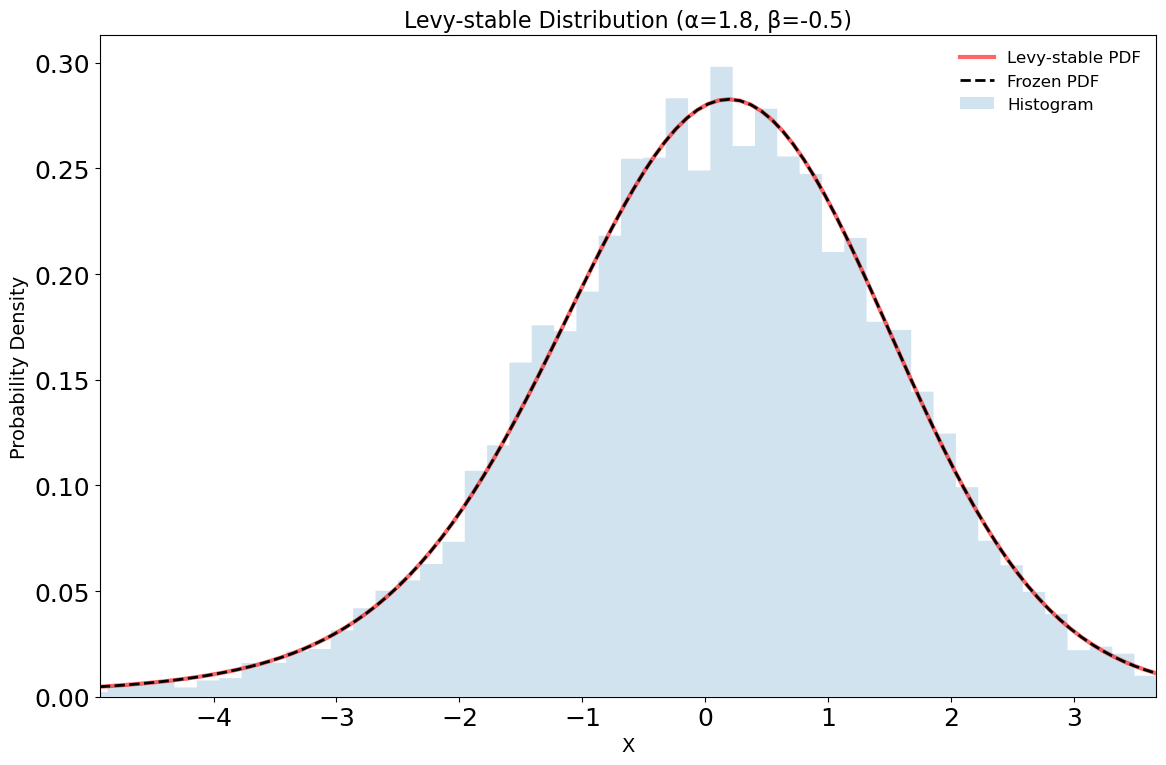

CDF accuracy check: True


In [30]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set parameters for the Levy-stable distribution
alpha, beta = 1.8, -0.5

# Calculate the first four moments
mean, var, skew, kurt = levy_stable.stats(alpha, beta, moments='mvsk')
print(f"Mean: {mean:.4f}, Variance: {var:.4f}, Skewness: {skew:.4f}, Kurtosis: {kurt:.4f}")

# Generate x values for plotting
x = np.linspace(levy_stable.ppf(0.01, alpha, beta),
                levy_stable.ppf(0.99, alpha, beta), 100)

# Plot the probability density function (PDF)
ax.plot(x, levy_stable.pdf(x, alpha, beta),
        'r-', lw=3, alpha=0.6, label='Levy-stable PDF')

# Create a frozen distribution and plot its PDF
rv = levy_stable(alpha, beta)
ax.plot(x, rv.pdf(x), 'k--', lw=2, label='Frozen PDF')

# Generate random numbers
r = levy_stable.rvs(alpha, beta, size=10000)

# Plot the histogram of random numbers
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='Histogram')

# Set plot limits and labels
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.set_title(f'Levy-stable Distribution (α={alpha}, β={beta})', fontsize=16)

# Add legend
ax.legend(loc='best', frameon=False, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Check accuracy of CDF and PPF
vals = levy_stable.ppf([0.001, 0.5, 0.999], alpha, beta)
print("CDF accuracy check:", np.allclose([0.001, 0.5, 0.999], levy_stable.cdf(vals, alpha, beta)))

0.1454284983635481


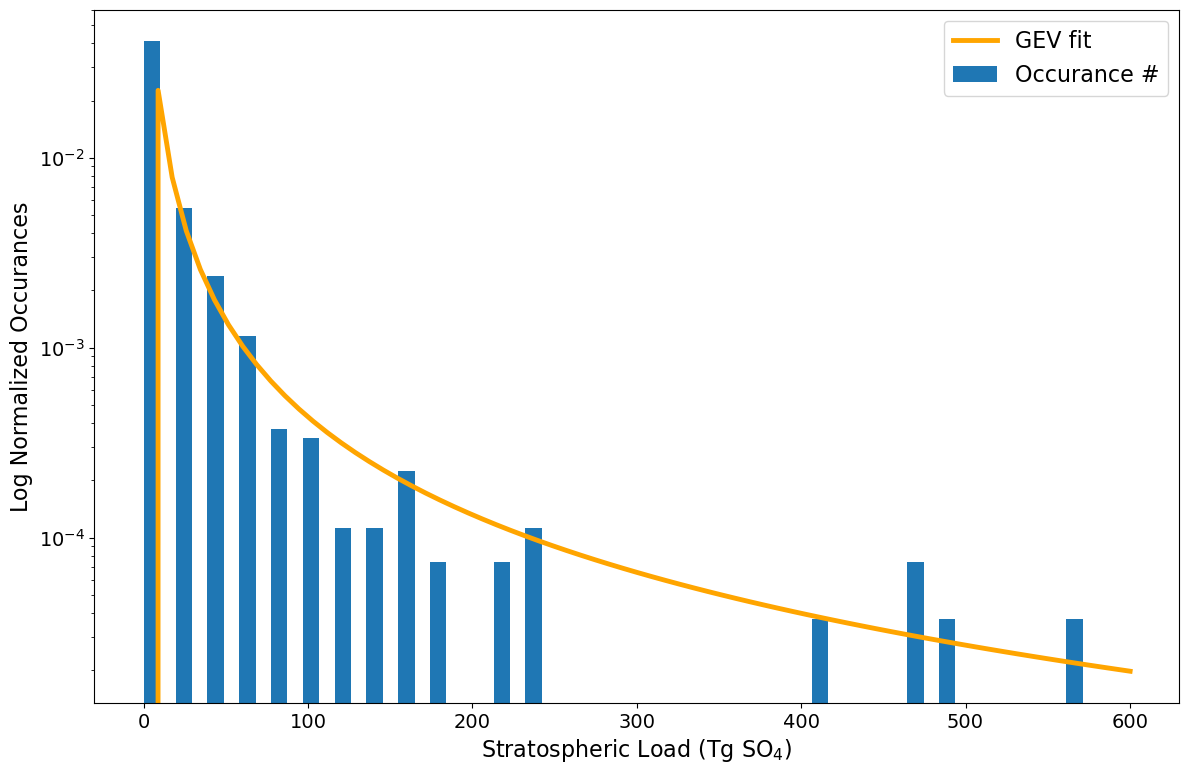

In [31]:
fig=plt.figure(figsize=(14,9))
ax = plt.subplot(111)
#shape, loc, scale = gev.fit(mass)

#print(shape)
#print(loc)
#print(scale)

l = loc + scale / shape
print (l)
xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)

hist, bins = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax.bar(bins[:-1], hist, width = 10, align='edge', label="Occurance #")

ax.plot(xx, yy, 'orange', linewidth = 3.5, label = "GEV fit")
ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurances")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)",size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurances",  16)
fshape = np.around(shape,2)
floc = np.around(loc,2)
fscale = np.around(scale,2)
#ax.set_title(r'$GEV(x) = exp[-\{1+s(x − a)/b\}^{-1/s}]$  s='+str(fshape)+'  a='+str(floc)+'  b='+str(fscale),size=16)
#ax.set_title(r'$alpha(x) = exp[-\{1+s(x − a)/b\}^{-1/s}]$  s='+str(fshape)+'  a='+str(floc)+'  b='+str(fscale),size=16)

plt.legend(fontsize=16)

0.1454284983635481


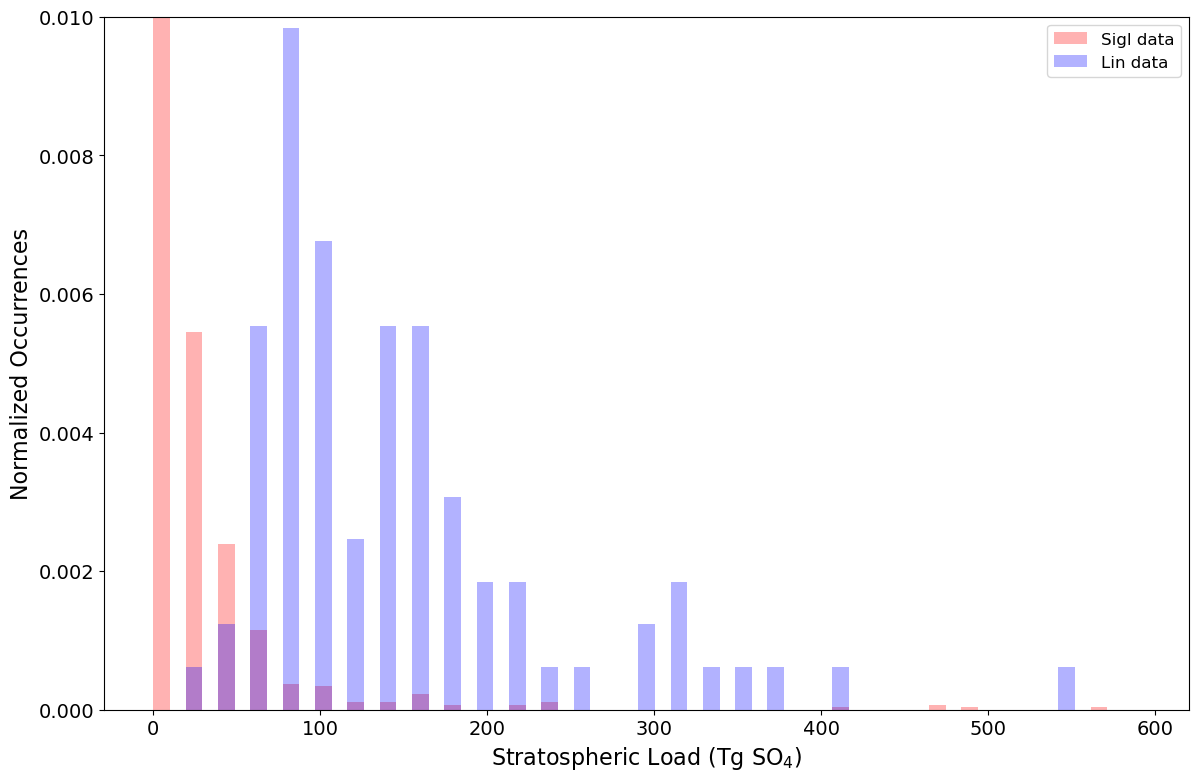

In [32]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Fit levy_stable distribution to Sigl data
#params = levy_stable.fit(mass)
#alpha, beta, loc, scale = params

#print(f"Sigl data fit - Alpha: {alpha:.2f}, Beta: {beta:.2f}, Location: {loc:.2f}, Scale: {scale:.2f}")

# Generate x values for plotting
x = np.linspace(0, 600, num=1000)

# Plot the probability density function (PDF) for Sigl data
#pdf_sigl = levy_stable.pdf(x, *params)
#ax.plot(x, pdf_sigl, 'r-', linewidth=3, alpha=0.6, label='Levy-stable fit (Sigl)')

# Plot histogram for Sigl data
hist_sigl, bins_sigl = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax.bar(bins_sigl[:-1], hist_sigl, width=10, align='edge', alpha=0.3, color='red', label="Sigl data")

# Fit levy_stable distribution to Lin data
#params_lin = levy_stable.fit(volc_load)
#alpha_lin, beta_lin, loc_lin, scale_lin = params_lin

#print(f"Lin data fit - Alpha: {alpha_lin:.2f}, Beta: {beta_lin:.2f}, Location: {loc_lin:.2f}, Scale: {scale_lin:.2f}")

# Plot the probability density function (PDF) for Lin data
#pdf_lin = levy_stable.pdf(x, *params_lin)
#ax.plot(x, pdf_lin, 'b-', linewidth=3, alpha=0.6, label='Levy-stable fit (Lin)')

# Plot histogram for Lin data
hist_lin, bins_lin = np.histogram(volc_load, bins=31, range=(0, 600), density=True)
ax.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="Lin data")

#ax.set_yscale('log')
ax.set_ylabel("Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Normalized Occurrences", 16)

#ax.set_title('Levy-stable distribution fit for Sigl and Lin data', size=16)
ax.set_ylim(0, 0.01)
plt.legend(fontsize=12)

#sigl gev

l = loc + scale / shape
print (l)
xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)


icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure_LevyStable_sigl_lin_2022.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_LevyStable_sigl_lin_2022.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

plt.show()

In [33]:
gicc05_age[20:]

20    24668.896552
21    25460.344828
22    25759.333333
23    25939.870968
24    27796.666667
          ...     
80    58355.241379
81    59180.090909
82    59316.551724
83    59545.142857
84    59647.400000
Name: Unnamed: 1, Length: 65, dtype: float64

In [34]:
mis3_lin_volc_load = volc_load[20:]

In [35]:
sigl_shape, sigl_loc, sigl_scale = gev.fit(mass)
print(f"Fitted parameters:\nShape: {sigl_shape:.5f}, Location: {sigl_loc:.5f}, Scale: {sigl_scale:.5f}")

Fitted parameters:
Shape: -1.34426, Location: 2.49871, Scale: 3.16342


In [36]:
lin_shape, lin_loc, lin_scale = gev.fit(mis3_lin_volc_load)
print(f"Fitted parameters:\nShape: {lin_shape:.5f}, Location: {lin_loc:.5f}, Scale: {lin_scale:.5f}")

Fitted parameters:
Shape: -0.46851, Location: 107.23891, Scale: 51.76101


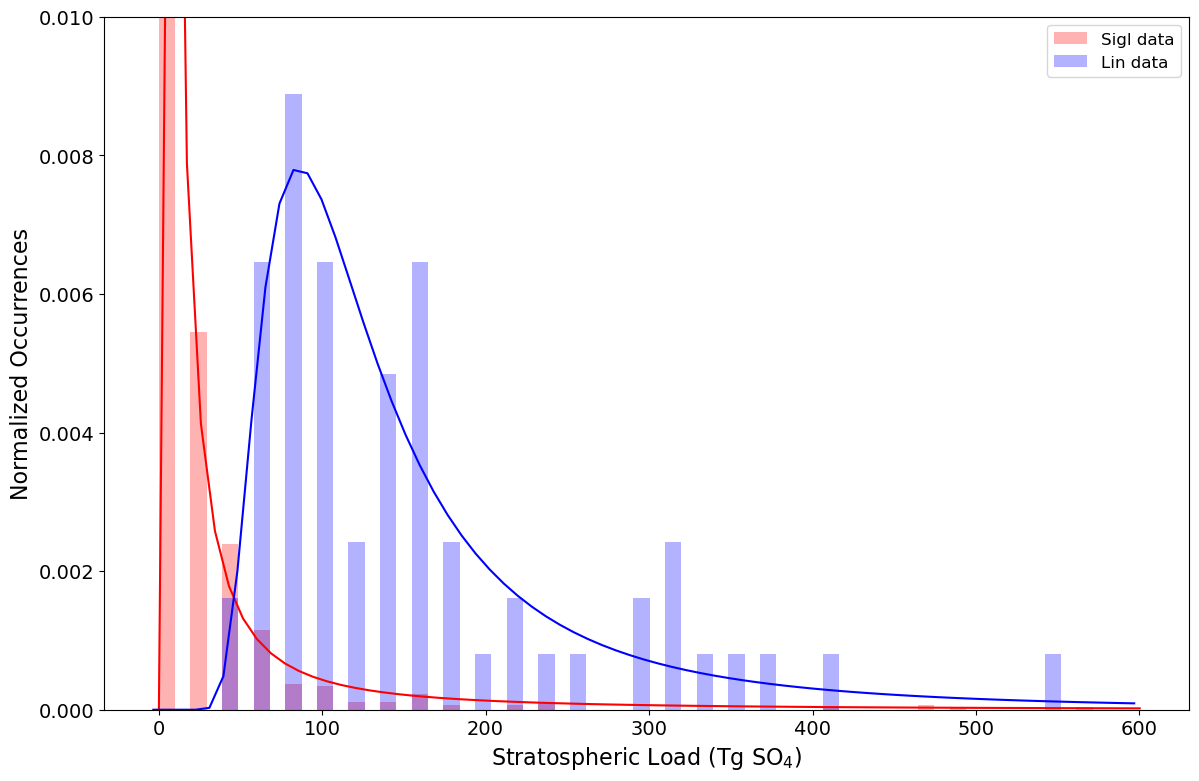

In [37]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))


# Plot histogram for Sigl data
hist_sigl, bins_sigl = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax.bar(bins_sigl[:-1], hist_sigl, width=10, align='edge', alpha=0.3, color='red', label="Sigl data")

# Plot histogram for Lin data
hist_lin, bins_lin = np.histogram(mis3_lin_volc_load , bins=31, range=(0, 600), density=True)
ax.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="Lin data")

#ax.set_yscale('log')
ax.set_ylabel("Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Normalized Occurrences", 16)

#ax.set_title('Levy-stable distribution fit for Sigl and Lin data', size=16)
ax.set_ylim(0, 0.01)
plt.legend(fontsize=12)

#sigl gev

sigl_l = sigl_loc + sigl_scale / sigl_shape
#print (sigl_l)
sigl_xx = np.linspace(sigl_l+0.00001, sigl_l+0.00001+600, num=71)
sigl_yy = gev.pdf(xx, sigl_shape, sigl_loc, sigl_scale)
ax.plot(sigl_xx, sigl_yy, 'red', linewidth = 1.5, label = "Sigl GEV fit")

#lin gev

lin_l = lin_loc + lin_scale / lin_shape
#print (lin_l)
lin_xx = np.linspace(lin_l+0.00001, lin_l+0.00001+600, num=71)
lin_yy = gev.pdf(xx, lin_shape, lin_loc, lin_scale)
ax.plot(lin_xx, lin_yy, 'blue', linewidth = 1.5, label = "Sigl GEV fit")


icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure_LevyStable_sigl_lin_2022.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_LevyStable_sigl_lin_2022.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

plt.show()

(1e-05, 0.1)

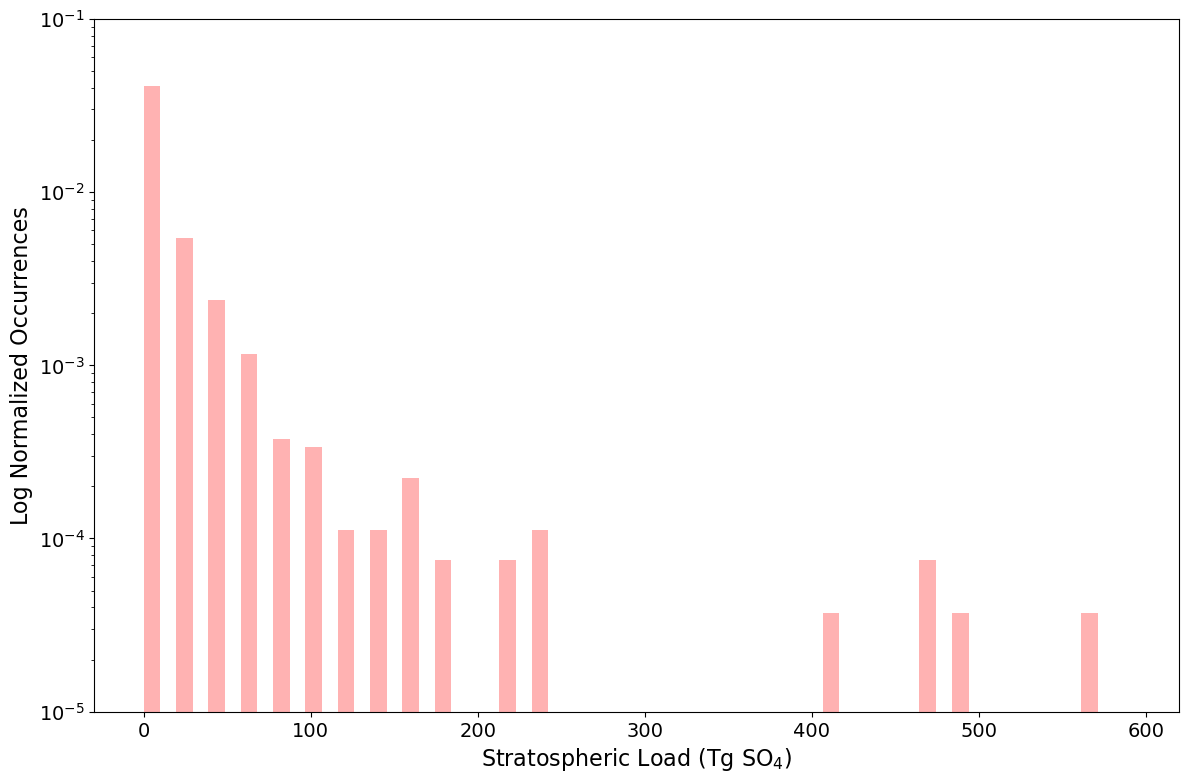

In [38]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))


# Plot histogram for Sigl data
hist_sigl, bins_sigl = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax.bar(bins_sigl[:-1], hist_sigl, width=10, align='edge', alpha=0.3, color='red', label="Sigl data")


ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurrences", 16)
ax.set_ylim(1.e-5,1.e-1)


(1e-05, 0.1)

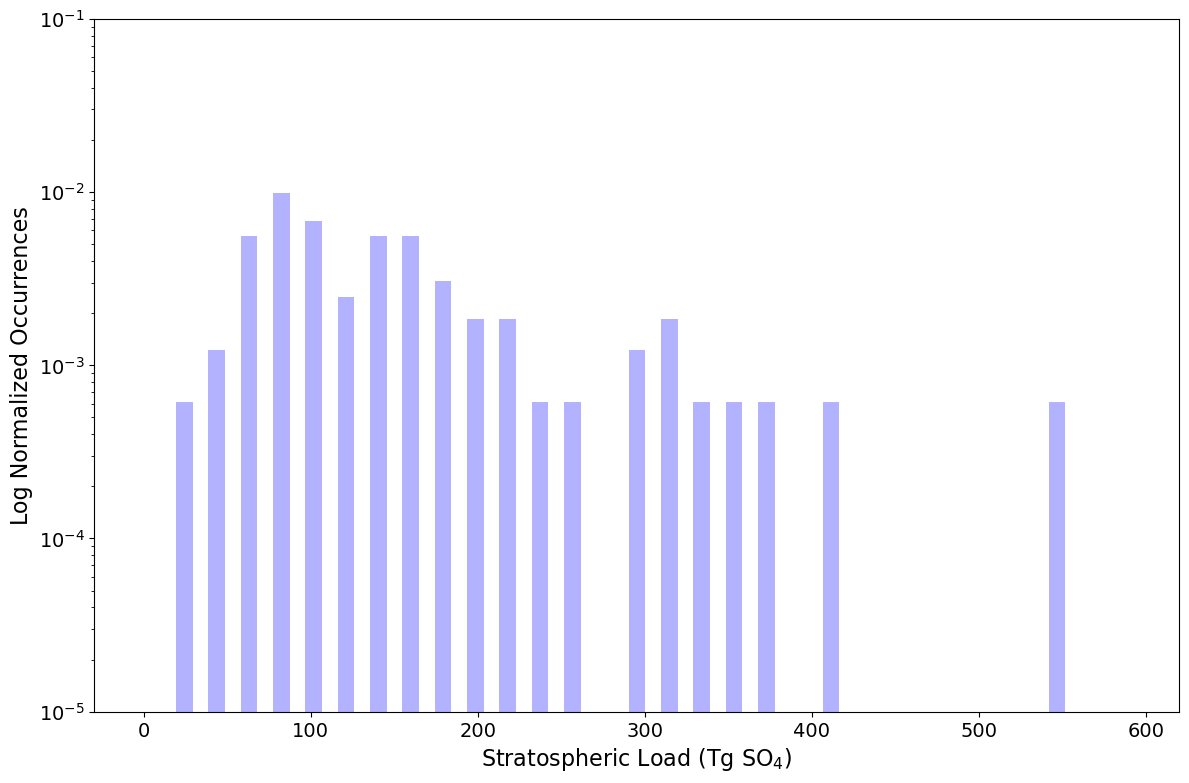

In [39]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))


# Plot histogram for Lin data
hist_lin, bins_lin = np.histogram(volc_load, bins=31, range=(0, 600), density=True)
ax.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="Lin data")

ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurrences", 16)
ax.set_ylim(1.e-5,1.e-1)


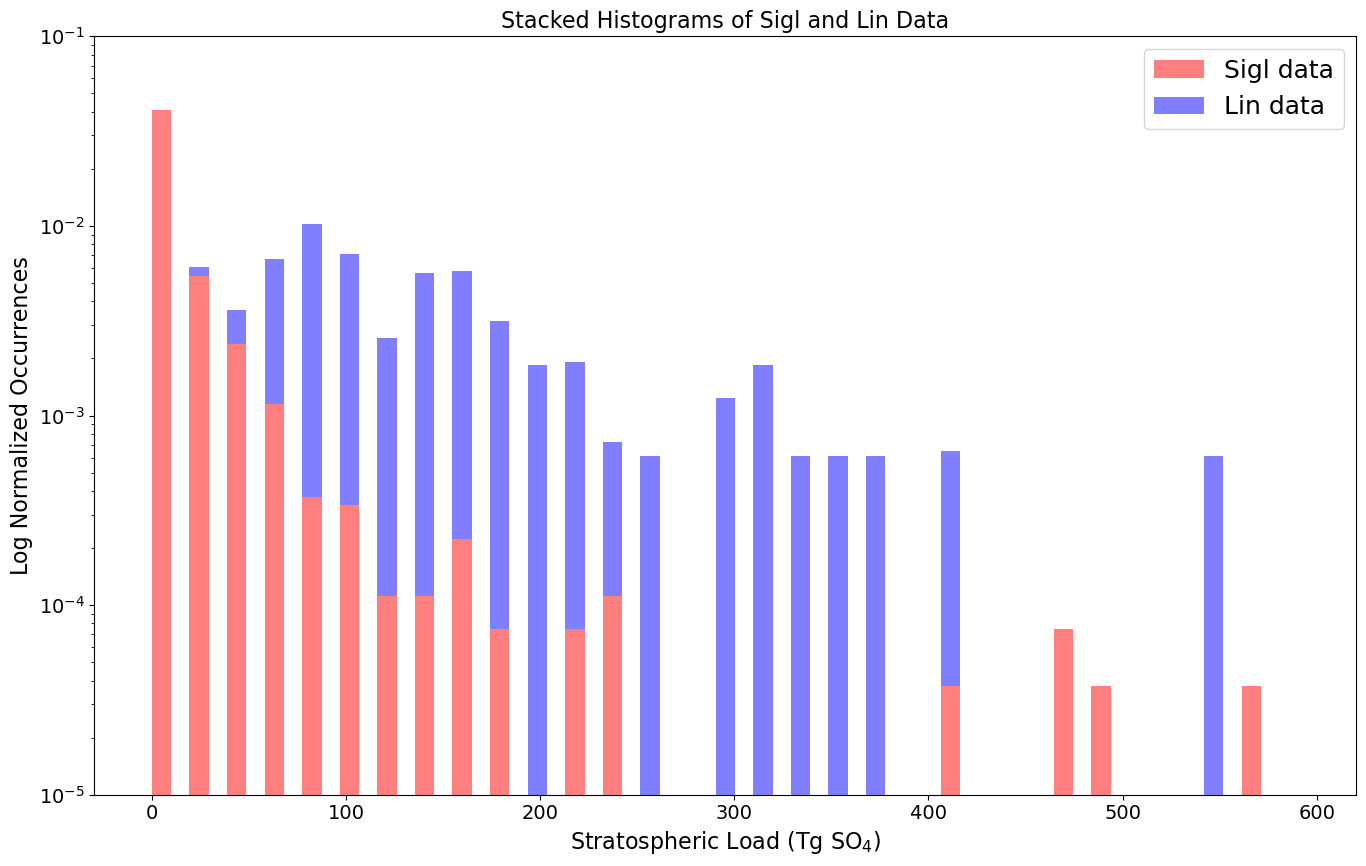

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Calculate histograms for both datasets
hist_sigl, bins_sigl = np.histogram(mass, bins=31, range=(0, 600), density=True)
hist_lin, bins_lin = np.histogram(volc_load, bins=31, range=(0, 600), density=True)

# Plot stacked histograms
width = 10  # width of bars
ax.bar(bins_sigl[:-1], hist_sigl, width=width, align='edge', alpha=0.5, color='red', label="Sigl data")
ax.bar(bins_lin[:-1], hist_lin, width=width, align='edge', alpha=0.5, color='blue', label="Lin data", bottom=hist_sigl)

ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurrences", 16)

ax.legend()
ax.set_ylim(1.e-5,1.e-1)
plt.title("Stacked Histograms of Sigl and Lin Data", size=16)
plt.tight_layout()


In [41]:
volc_load.values

array([153.8648    , 199.78416667, 152.96892436,  82.682     ,
       103.6745    , 200.78011699,  28.2541    ,  77.05      ,
       220.51170852,  77.8       ,  95.502     , 103.75      ,
       186.15797321, 132.11666667,  89.66806591, 156.23333333,
        84.188     , 105.72033333, 152.70372964, 192.7       ,
       160.65783333, 382.28      , 233.06298818,  79.73183333,
       168.02783333, 117.58233333, 185.86666667, 327.54766667,
       154.2655    , 155.23359092, 265.76006882,  86.2       ,
        93.3       ,  59.2       ,  71.73      , 224.10333333,
        89.53333333, 180.12067008,  86.60866667, 120.3885    ,
       144.74233333, 413.90023062,  90.19      , 145.6728113 ,
       151.56      , 224.14688247, 168.09201015, 315.48585591,
        99.35      , 306.55566667, 100.1365    , 185.24333333,
       161.52759461,  63.004     ,  91.2       , 161.9       ,
        65.738     , 340.65      , 104.61666667, 544.681     ,
       114.62889021, 165.8831513 , 316.2       , 197.87

In [42]:
gicc05_age

0     10480.926070
1     11304.500000
2     12170.400000
3     12240.690909
4     12754.814815
          ...     
80    58355.241379
81    59180.090909
82    59316.551724
83    59545.142857
84    59647.400000
Name: Unnamed: 1, Length: 85, dtype: float64

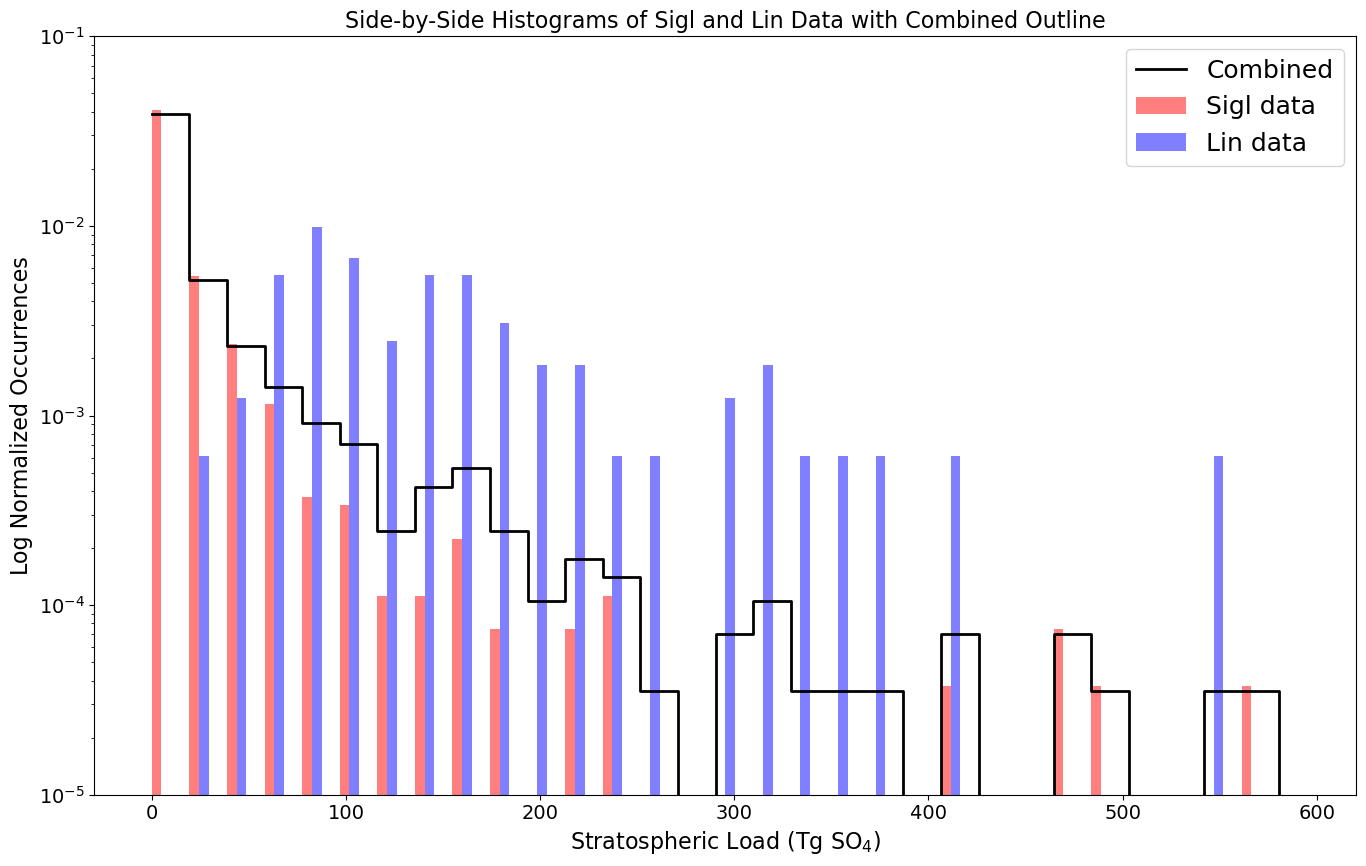

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Combine the datasets
combined_data = np.concatenate([mass, volc_load])

# Calculate histograms for all datasets
hist_sigl, bins = np.histogram(mass, bins=31, range=(0, 600), density=True)
hist_lin, _ = np.histogram(volc_load, bins=bins, density=True)
hist_combined, _ = np.histogram(combined_data, bins=bins, density=True)

# Plot side-by-side histograms
width = 5  # width of bars (half of before to fit side by side)
ax.bar(bins[:-1], hist_sigl, width=width, align='edge', alpha=0.5, color='red', label="Sigl data")
ax.bar(bins[:-1]+width, hist_lin, width=width, align='edge', alpha=0.5, color='blue', label="Lin data")

# Plot the outline of the combined histogram
ax.step(bins[:-1], hist_combined, where='post', color='black', linewidth=2, label="Combined")

ax.set_yscale('log')
ax.set_ylabel("Log Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurrences", 16)

ax.legend()
ax.set_ylim(1.e-5, 1.e-1)
plt.title("Side-by-Side Histograms of Sigl and Lin Data with Combined Outline", size=16)
plt.tight_layout()

icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure_SideBySide_Histogram_sigl_lin_combined_2022.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure_SideBySide_Histogram_sigl_lin_combined_2022.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

plt.show()

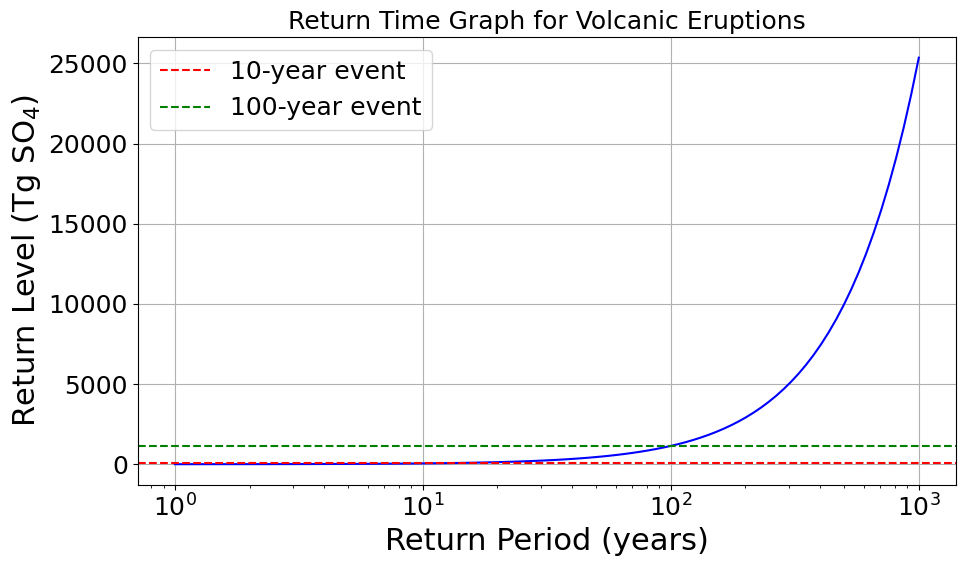

10-year event: 48.61 Tg SO4
100-year event: 1141.09 Tg SO4
1000-year event: 25360.97 Tg SO4


In [44]:
# this is incorrect because of timescale interval is not 1 year

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming 'mass' is your data array
# Fit GEV distribution
shape, loc, scale = stats.genextreme.fit(mass)

# Define return periods (in years)
return_periods = np.logspace(0, 3, 100)  # 1 to 1000 years, 100 points

# Calculate return levels
return_levels = stats.genextreme.isf(1/return_periods, c=shape, loc=loc, scale=scale)

# Plot return time graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(return_periods, return_levels, 'b-')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Return Level (Tg SO$_4$)')
ax.set_title('Return Time Graph for Volcanic Eruptions')
ax.grid(True)

# Add some reference lines
ax.axhline(stats.genextreme.isf(1/10, c=shape, loc=loc, scale=scale), color='r', linestyle='--', label='10-year event')
ax.axhline(stats.genextreme.isf(1/100, c=shape, loc=loc, scale=scale), color='g', linestyle='--', label='100-year event')

ax.legend()

plt.tight_layout()
plt.show()

# Print some key return levels
print(f"10-year event: {stats.genextreme.isf(1/10, c=shape, loc=loc, scale=scale):.2f} Tg SO4")
print(f"100-year event: {stats.genextreme.isf(1/100, c=shape, loc=loc, scale=scale):.2f} Tg SO4")
print(f"1000-year event: {stats.genextreme.isf(1/1000, c=shape, loc=loc, scale=scale):.2f} Tg SO4")

In [45]:
def estimate_return_level(quantile, loc, scale, shape):
    level = loc + scale / shape * (1 - (-np.log(quantile)) ** (shape))
    return level

In [46]:
sigl2022

<xarray.Dataset> Size: 100kB
Dimensions:     (nerup: 1384)
Dimensions without coordinates: nerup
Data variables:
    year        (nerup) float64 11kB ...
    yearCE      (nerup) float64 11kB ...
    month       (nerup) float64 11kB ...
    day         (nerup) float64 11kB ...
    lat         (nerup) float64 11kB ...
    vssi        (nerup) float64 11kB 4.44 1.04 9.09 0.28 ... 0.22 9.13 57.9 2.89
    hemi        (nerup) float64 11kB ...
    sigma_vssi  (nerup) float64 11kB ...
    duration    (nerup) float64 11kB ...
Attributes:
    title:    Ice core-inferred volcanic stratospheric sulfur injection for t...
    history:  Created Tue Jun  9 23:01:18 2020
    source:   Sigl et al., in preparation

In [47]:
sigl2022.year.values


array([ 1892.,  1886.,  1884., ..., -9491., -9493., -9496.], shape=(1384,))

In [48]:
sigl2022.yearCE.values


array([ 1892.,  1886.,  1884., ..., -9492., -9494., -9497.], shape=(1384,))

In [49]:
np.max(sigl2022.day.values)


np.float64(1.0)

In [50]:
sigl2022.year.values[0:100]

array([1892., 1886., 1884., 1876., 1863., 1861., 1855., 1844., 1835.,
       1831., 1822., 1815., 1809., 1795., 1783., 1767., 1762., 1754.,
       1739., 1729., 1719., 1702., 1694., 1673., 1666., 1661., 1646.,
       1641., 1634., 1621., 1600., 1594., 1591., 1586., 1577., 1568.,
       1559., 1555., 1540., 1527., 1512., 1505., 1495., 1490., 1480.,
       1477., 1477., 1470., 1458., 1453., 1447., 1428., 1418., 1414.,
       1390., 1385., 1381., 1378., 1344., 1342., 1336., 1330., 1290.,
       1284., 1276., 1269., 1265., 1258., 1241., 1234., 1229., 1227.,
       1214., 1209., 1205., 1199., 1191., 1188., 1181., 1181., 1171.,
       1152., 1146., 1126., 1115., 1112., 1109., 1091., 1081., 1065.,
       1044., 1038., 1029., 1022., 1015., 1008., 1006., 1004., 1002.,
       1001.])

In [51]:
sigl2022.year.values[-100:]

array([-8887., -8896., -8905., -8933., -8944., -8963., -8964., -8966.,
       -8969., -8970., -8982., -8990., -8994., -9001., -9009., -9013.,
       -9017., -9021., -9030., -9035., -9041., -9045., -9049., -9066.,
       -9070., -9082., -9092., -9125., -9137., -9140., -9141., -9143.,
       -9145., -9147., -9149., -9150., -9152., -9165., -9167., -9169.,
       -9170., -9173., -9175., -9176., -9178., -9180., -9183., -9183.,
       -9185., -9187., -9189., -9191., -9203., -9211., -9218., -9225.,
       -9241., -9243., -9246., -9256., -9273., -9277., -9290., -9298.,
       -9303., -9305., -9307., -9309., -9311., -9318., -9325., -9327.,
       -9329., -9331., -9334., -9340., -9344., -9347., -9349., -9351.,
       -9352., -9358., -9373., -9378., -9386., -9388., -9395., -9402.,
       -9411., -9418., -9421., -9427., -9433., -9439., -9450., -9463.,
       -9476., -9491., -9493., -9496.])

In [52]:
timevar = np.linspace(-9496+9496,1892+9496,11389)

In [53]:
timevar[-100:]

array([11289., 11290., 11291., 11292., 11293., 11294., 11295., 11296.,
       11297., 11298., 11299., 11300., 11301., 11302., 11303., 11304.,
       11305., 11306., 11307., 11308., 11309., 11310., 11311., 11312.,
       11313., 11314., 11315., 11316., 11317., 11318., 11319., 11320.,
       11321., 11322., 11323., 11324., 11325., 11326., 11327., 11328.,
       11329., 11330., 11331., 11332., 11333., 11334., 11335., 11336.,
       11337., 11338., 11339., 11340., 11341., 11342., 11343., 11344.,
       11345., 11346., 11347., 11348., 11349., 11350., 11351., 11352.,
       11353., 11354., 11355., 11356., 11357., 11358., 11359., 11360.,
       11361., 11362., 11363., 11364., 11365., 11366., 11367., 11368.,
       11369., 11370., 11371., 11372., 11373., 11374., 11375., 11376.,
       11377., 11378., 11379., 11380., 11381., 11382., 11383., 11384.,
       11385., 11386., 11387., 11388.])

In [54]:
contmass = (sigl2022.vssi*3).values

In [55]:
contmass.shape

(1384,)

In [56]:
sigl2022.year.values.shape


(1384,)

In [57]:

# Your existing data
sigl2022_years = sigl2022.year.values
contmass = (sigl2022.vssi*3).values
sigl_lats = sigl_hol_volc_data.lat

# Your new time vector
timevar = np.linspace(-9496+9496, 1892+9496, 11389)

# Create a new array of zeros
new_contmass = np.zeros_like(timevar)
new_latitude = np.zeros_like(timevar)

# Find the indices in timevar that correspond to sigl2022_years
indices = np.searchsorted(timevar, sigl2022_years + 9496)

# Fill in the values from contmass at those indices
new_contmass[indices] = contmass
new_latitude[indices] = sigl_lats

# Now new_contmass is a continuous series with zeros filled in

In [58]:

# Your existing data
sigl2022_years = sigl2022.year.values
contmass = (sigl2022.vssi*3).values
sigl_lats = sigl_hol_volc_data.lat

# Your new time vector
timevar = np.linspace(-9496+9496, 1892+9496, 11389)

# Create new arrays filled with np.nan
new_contmass = np.full_like(timevar, np.nan)
new_latitude = np.full_like(timevar, np.nan)

# Find the indices in timevar that correspond to sigl2022_years
indices = np.searchsorted(timevar, sigl2022_years + 9496)

# Fill in the values from contmass and sigl_lats at those indices
new_contmass[indices] = contmass
new_latitude[indices] = sigl_lats

# Now new_contmass and new_latitude are continuous series with np.nan filled in for missing values

In [59]:
new_contmass[0:100]

array([  8.67,    nan,    nan, 173.7 ,    nan,  27.39,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,   0.66,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,  16.95,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,   1.32,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,  20.25,    nan,    nan,    nan,    nan,    nan,  15.87,
          nan,    nan,    nan,    nan,    nan,  15.69,    nan,    nan,
          nan,    nan,    nan,  18.21,    nan,    nan,  33.66,    nan,
          nan,    nan,    nan,    nan,    nan,   3.24,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,  37.71,    nan,
          nan,    nan,    nan,    nan])

In [60]:
timevar[0:100]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [61]:
contmass[0:100]

array([ 13.32,   3.12,  27.27,   0.84,  17.22,   0.72,   6.78,   4.35,
        16.8 ,  53.25,   3.66, 110.85,  51.15,   3.18,  33.21,   7.89,
        16.35,   5.22,  11.43,  12.81,   3.06,   3.45,  54.21,  17.34,
        12.09,  13.86,   5.04,  66.15,   5.61,   5.4 ,  50.82,  28.86,
         1.29,  32.7 ,   0.75,   6.39,   0.66,   0.69,   7.26,   2.85,
         8.97,   2.46,   3.06,   2.49,  12.81,   6.06,  16.14,   5.22,
       112.47,  32.31,   1.32,   1.95,   2.94,   1.2 ,   1.68,   8.01,
         0.75,   8.16,  42.96,   5.4 ,   0.87,  28.83,   4.02,  43.26,
        32.01,  19.62,   3.12, 225.93,   1.74,   0.63,  91.2 ,   0.72,
         2.91,  12.84,   3.  ,  15.78,  24.87,   3.15,  35.7 ,   1.38,
        56.76,   0.57,   3.12,   7.68,   3.57,   2.49,  57.54,   1.02,
         1.47,   2.22,   0.48,   5.61,  24.09,   4.77,   1.14,  11.85,
         4.95,   0.48,   0.48,   7.41])

In [62]:
contmass[-100:]

array([  1.29,  12.18,  43.71,   0.93,   2.52,  16.38,   1.38,   2.4 ,
        13.89,   0.69,   5.37,  29.64,   0.96,   1.17, 251.01,   1.17,
        25.29,  13.77,  49.59,  96.72,  16.92,   1.35,   4.65,  41.55,
        20.94,  36.99,   1.08,  38.67,   0.87,  36.54,   0.87,   1.95,
         2.1 ,   1.74,   2.46,   2.73,  59.58,   1.14,   1.02,   0.9 ,
         1.11,  10.41,  13.62,   2.19,   1.62,   2.07,  61.08,   2.49,
         2.04,  39.06,   1.11,   1.47,  70.47,  17.4 ,  61.26, 467.85,
        23.19,   0.84,   1.35,  60.33,   0.87,   5.22,   1.17,   8.19,
         2.16,   1.59,   2.49,   1.08,   2.4 ,  24.33,   2.28,   1.68,
         1.95,   2.13,   2.19,   9.12,   2.82,   1.26,   1.83,   1.02,
        20.07,   7.14,  11.79,   8.82,   0.57,  41.52, 128.91,  37.71,
         3.24,  33.66,  18.21,  15.69,  15.87,  20.25,   1.32,  16.95,
         0.66,  27.39, 173.7 ,   8.67])

In [63]:
sigl2022_years[0:100]

array([1892., 1886., 1884., 1876., 1863., 1861., 1855., 1844., 1835.,
       1831., 1822., 1815., 1809., 1795., 1783., 1767., 1762., 1754.,
       1739., 1729., 1719., 1702., 1694., 1673., 1666., 1661., 1646.,
       1641., 1634., 1621., 1600., 1594., 1591., 1586., 1577., 1568.,
       1559., 1555., 1540., 1527., 1512., 1505., 1495., 1490., 1480.,
       1477., 1477., 1470., 1458., 1453., 1447., 1428., 1418., 1414.,
       1390., 1385., 1381., 1378., 1344., 1342., 1336., 1330., 1290.,
       1284., 1276., 1269., 1265., 1258., 1241., 1234., 1229., 1227.,
       1214., 1209., 1205., 1199., 1191., 1188., 1181., 1181., 1171.,
       1152., 1146., 1126., 1115., 1112., 1109., 1091., 1081., 1065.,
       1044., 1038., 1029., 1022., 1015., 1008., 1006., 1004., 1002.,
       1001.])

In [64]:
sigl2022_years[-100:]

array([-8887., -8896., -8905., -8933., -8944., -8963., -8964., -8966.,
       -8969., -8970., -8982., -8990., -8994., -9001., -9009., -9013.,
       -9017., -9021., -9030., -9035., -9041., -9045., -9049., -9066.,
       -9070., -9082., -9092., -9125., -9137., -9140., -9141., -9143.,
       -9145., -9147., -9149., -9150., -9152., -9165., -9167., -9169.,
       -9170., -9173., -9175., -9176., -9178., -9180., -9183., -9183.,
       -9185., -9187., -9189., -9191., -9203., -9211., -9218., -9225.,
       -9241., -9243., -9246., -9256., -9273., -9277., -9290., -9298.,
       -9303., -9305., -9307., -9309., -9311., -9318., -9325., -9327.,
       -9329., -9331., -9334., -9340., -9344., -9347., -9349., -9351.,
       -9352., -9358., -9373., -9378., -9386., -9388., -9395., -9402.,
       -9411., -9418., -9421., -9427., -9433., -9439., -9450., -9463.,
       -9476., -9491., -9493., -9496.])

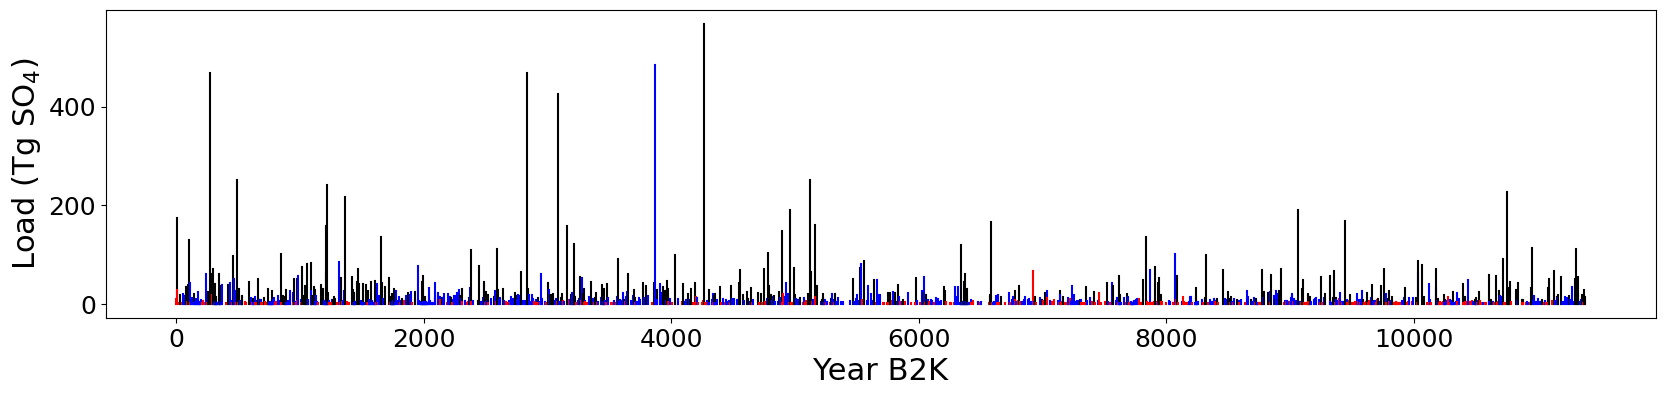

In [65]:
# plot chronologies

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 25
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
#
for e in range(len(timevar)):
    if new_latitude[e] > 20.0:
        ax.plot([timevar[e], timevar[e]],[0, new_contmass[e]],color='b')
    elif new_latitude[e] >= -20 and new_latitude[e] <= 20:
        ax.plot([timevar[e], timevar[e]],[0, new_contmass[e]],color='k')
    elif new_latitude[e] < -20.:
        ax.plot([timevar[e], timevar[e]],[0, new_contmass[e]],color='r')
#ax.set_xlim(24000,60000) 
ax.set_ylabel('Load (Tg SO$_4$)')
#ax.set_ylim(0,180)
ax.set_xlabel('Year B2K')
#axes[axId].set_ylabel('Load (Tg)')
#ax.set_yticks([0,25,50,75,100,125,150,175])


#for e in range(len(year)):
#    if flag[e] == 1:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='k')
#    elif flag[e] == 2:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='b')
#    elif flag[e] == 3:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='r')
icepaperdir="/home/guido/Dropbox/plots/volcanic/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Timeseries_sigl_start0.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
    plt.savefig(icepaperdir+"Timeseries_sigl_start0.pdf", dpi=300, facecolor=fig.get_facecolor(), transparent=True)

In [66]:
## We can use this data set to rebin the data and do extreme value analysis return time with evenly spaced time intervals

# Your actual data (this is just a placeholder for illustration, replace it with your actual dataset)
time_series = timevar

load_series = new_contmass

# Convert the time_series and load_series into a DataFrame
df = pd.DataFrame({'Time': time_series, 'Load': load_series})

# Define custom bin edges based on time_series values
# You can use a fixed number of bins or custom breakpoints.
# Here, we use 5 bins for illustration
num_bins = 242 # adjust higher until there are no more nan's
bins = pd.cut(df['Time'], bins=num_bins)

# Add the bin information to the DataFrame
df['Bin'] = bins

# Group by the 'Bin' and calculate the maximum 'Load' in each bin
sigl_rebinned_df = df.groupby('Bin').agg(MaxLoad=('Load', 'max'))

# Extract the bin edges (lower and upper bounds)
sigl_rebinned_df['BinStart'] = sigl_rebinned_df.index.categories.left
sigl_rebinned_df['BinEnd'] = sigl_rebinned_df.index.categories.right

# Calculate the delta time for each bin
sigl_rebinned_df['DeltaTime'] = sigl_rebinned_df['BinEnd'] - sigl_rebinned_df['BinStart']

# Calculate the middle of the bin (BinMid)
sigl_rebinned_df['BinMid'] = (sigl_rebinned_df['BinStart'] + sigl_rebinned_df['BinEnd']) / 2

# Reorder the columns
sigl_rebinned_df = sigl_rebinned_df[['BinStart', 'BinEnd', 'BinMid', 'DeltaTime', 'MaxLoad']]

# Output the rebinned dataset
#print(sigl_rebinned_df)
#print(np.min(sigl_rebinned_df["MaxLoad"]))
#print(np.max(sigl_rebinned_df["MaxLoad"]))

# Assuming sigl_rebinned_df is your DataFrame
if sigl_rebinned_df['MaxLoad'].isna().any():
    print("There are NaN values in the 'MaxLoad' column.")
else:
    print("No NaN values in the 'MaxLoad' column.")
sigl_new_rebinned_df  = sigl_rebinned_df[1:]    

No NaN values in the 'MaxLoad' column.


/tmp/ipykernel_287523/3129758532.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sigl_rebinned_df = df.groupby('Bin').agg(MaxLoad=('Load', 'max'))


In [67]:
sigl_new_rebinned_df

,BinStart,BinEnd,BinMid,DeltaTime,MaxLoad
Bin,,,,,
"(47.058, 94.116]",47.058,94.116,70.5870,47.058,37.71
"(94.116, 141.174]",94.116,141.174,117.6450,47.058,128.91
"(141.174, 188.231]",141.174,188.231,164.7025,47.057,24.33
"(188.231, 235.289]",188.231,235.289,211.7600,47.058,8.19
"(235.289, 282.347]",235.289,282.347,258.8180,47.058,467.85
...,...,...,...,...,...
"(11152.711, 11199.769]",11152.711,11199.769,11176.2400,47.058,54.21
"(11199.769, 11246.826]",11199.769,11246.826,11223.2975,47.057,12.81
"(11246.826, 11293.884]",11246.826,11293.884,11270.3550,47.058,33.21


[[<matplotlib.lines.Line2D at 0x7ee802a88ef0>],

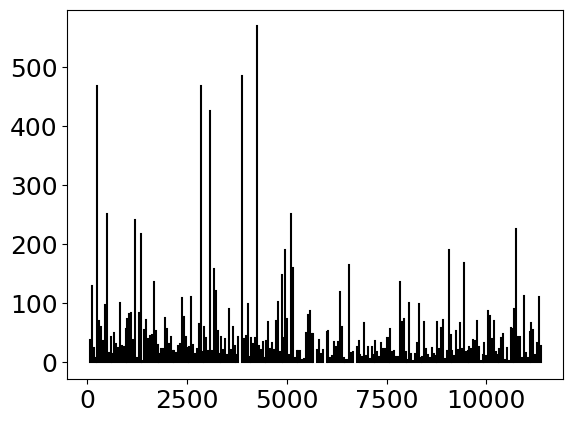

In [68]:
[ plt.plot([sigl_new_rebinned_df["BinMid"].values[e],sigl_new_rebinned_df["BinMid"].values[e]], [0, sigl_new_rebinned_df["MaxLoad"].values[e]],color='k') 
 for e in range(len(sigl_new_rebinned_df["BinMid"])) ]

-0.551963396388254
22.867942330855666
20.995681539070155


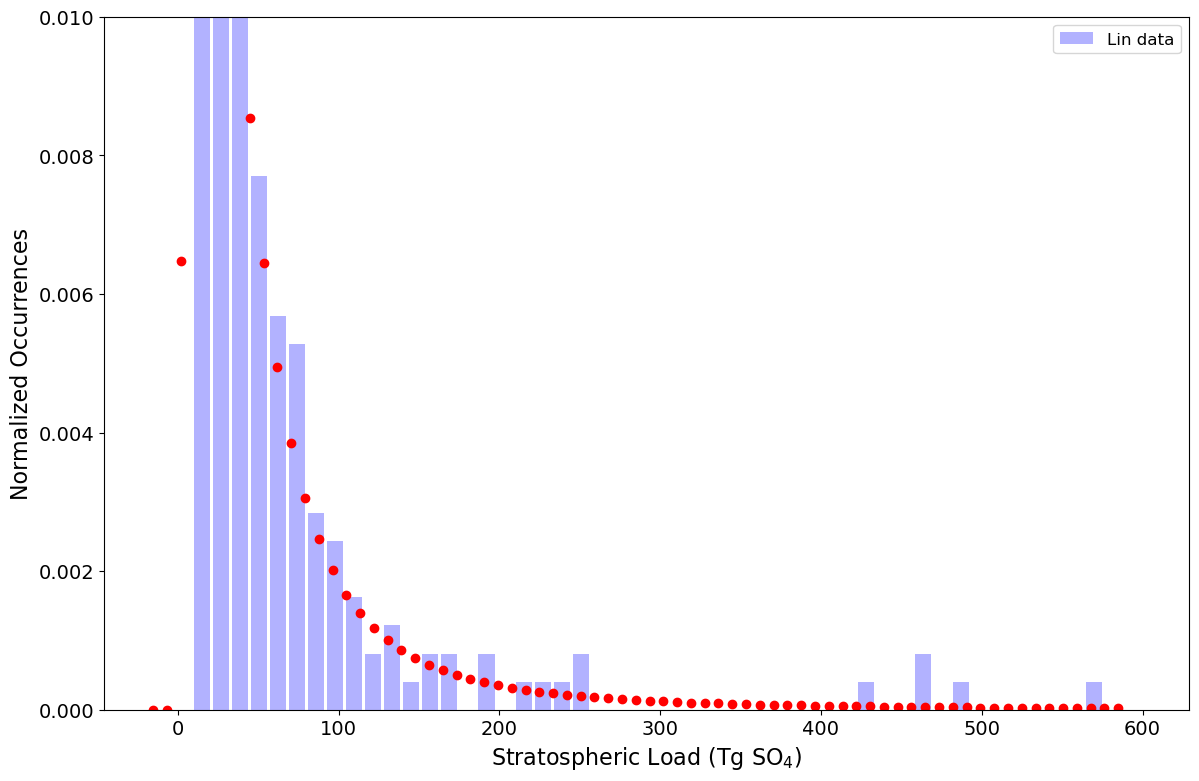

In [69]:
# Set up the plot
fig, ax = plt.subplots(figsize=(14, 9))

# Plot histogram for Lin data
hist_lin, bins_lin = np.histogram(sigl_new_rebinned_df["MaxLoad"], bins=50, range=(10, 600), density=True)
ax.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="Lin data")

#ax.set_yscale('log')
ax.set_ylabel("Normalized Occurrences")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)", size=16)
setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Normalized Occurrences", 16)

#ax.set_title('Levy-stable distribution fit for Sigl and Lin data', size=16)
ax.set_ylim(0, 0.01)
plt.legend(fontsize=12)

def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return shape, loc, scale


shape, loc, scale = main(sigl_new_rebinned_df["MaxLoad"].values)

print(shape)
print(loc)
print(scale)

l = loc + scale / shape

xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)

#hist, bins = np.histogram(sigl_new_rebinned_df["MaxLoad"].values, bins=5, range=(0, 600), density=True)
#plt.bar(bins[:-1], hist, width = 2, align='edge')

plt.plot(xx, yy, 'ro')

# these are the GEV parameters for the massaged Lin data
sigl_ml_loc = loc 
sigl_ml_scale = scale
sigl_ml_shape = shape


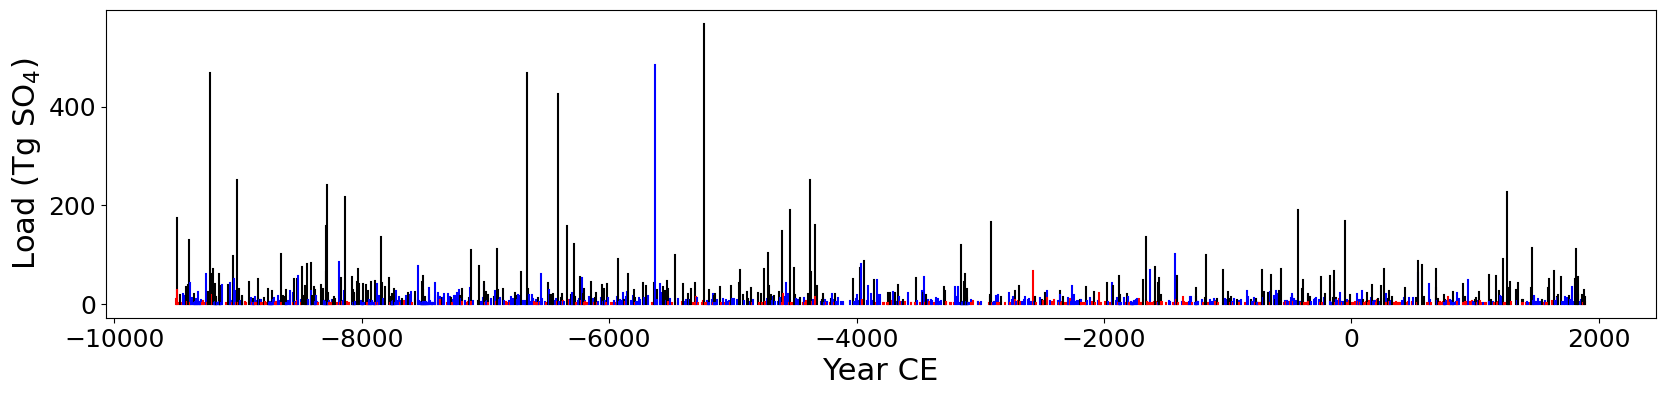

In [70]:
# plot chronologies
# add offset to get it with correct dates before 2K data (data is from 1892)
t_shift = 2000 - 1892
t_start = -11389 + 1892
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 25
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(111)
#
for e in range(len(timevar)):
    if new_latitude[e] > 20.0:
        ax.plot([t_start + timevar[e], t_start + timevar[e]],[0, new_contmass[e]],color='b')
    elif new_latitude[e] >= -20 and new_latitude[e] <= 20:
        ax.plot([t_start + timevar[e], t_start + timevar[e]],[0, new_contmass[e]],color='k')
    elif new_latitude[e] < -20.:
        ax.plot([t_start + timevar[e], t_start + timevar[e]],[0, new_contmass[e]],color='r')
#ax.set_xlim(24000,60000) 
ax.set_ylabel('Load (Tg SO$_4$)')
#ax.set_ylim(0,180)
ax.set_xlabel('Year CE')
#axes[axId].set_ylabel('Load (Tg)')
#ax.set_yticks([0,25,50,75,100,125,150,175])


#for e in range(len(year)):
#    if flag[e] == 1:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='k')
#    elif flag[e] == 2:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='b')
#    elif flag[e] == 3:
#        ax.plot([year[e],year[e]],[0,mass[e]],color='r')
icepaperdir="/home/guido/Dropbox/plots/volcanic/"
saveplot=False
if saveplot:
    plt.savefig(icepaperdir+"Timeseries_sigl_start0.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
    plt.savefig(icepaperdir+"Timeseries_sigl_start0.pdf", dpi=300, facecolor=fig.get_facecolor(), transparent=True)

In [71]:
shape, loc, scale = gev.fit(mass)
print(f"Fitted parameters:\nShape: {shape:.5f}, Location: {loc:.5f}, Scale: {scale:.5f}")

Fitted parameters:
Shape: -1.34426, Location: 2.49871, Scale: 3.16342


In [72]:
#shape, loc, scale = gev.fit(new_contmass)
#print(f"Fitted parameters:\nShape: {shape:.5f}, Location: {loc:.5f}, Scale: {scale:.5f}")

0.1454284983635481


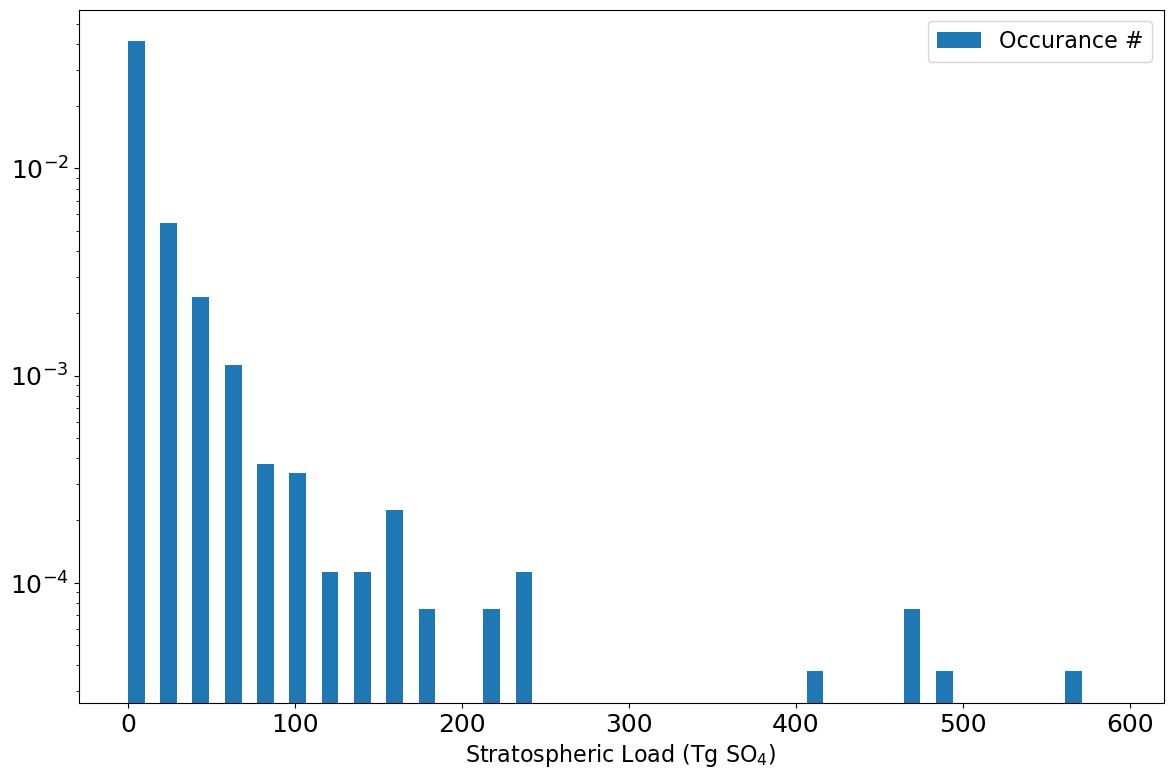

In [73]:
fig=plt.figure(figsize=(14,9))
ax = plt.subplot(111)
#shape, loc, scale = gev.fit(mass)

#print(shape)
#print(loc)
#print(scale)

l = loc + scale / shape
print (l)
xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
yy = gev.pdf(xx, shape, loc, scale)

hist, bins = np.histogram(new_contmass, bins=31, range=(0, 600), density=True)
ax.bar(bins[:-1], hist, width = 10, align='edge', label="Occurance #")

# plot GEV dist
#ax.plot(xx, yy, 'orange', linewidth = 3.5, label = "GEV fit")
# set log scale
ax.set_yscale('log')
#ax.set_ylabel("Log Normalized Occurances")
ax.set_xlabel("Stratospheric Load (Tg SO$_4$)",size=16)
#setaxesfsize(ax, 14, "Stratospheric Load (Tg SO$_4$)", "Log Normalized Occurances",  16)
fshape = np.around(shape,2)
floc = np.around(loc,2)
fscale = np.around(scale,2)
#ax.set_title(r'$GEV(x) = exp[-\{1+s(x − a)/b\}^{-1/s}]$  s='+str(fshape)+'  a='+str(floc)+'  b='+str(fscale),size=16)
#ax.set_title(r'$alpha(x) = exp[-\{1+s(x − a)/b\}^{-1/s}]$  s='+str(fshape)+'  a='+str(floc)+'  b='+str(fscale),size=16)
#ax.set_xlim(-10,100)
#ax.set_ylim(1.e-3,1)
plt.legend(fontsize=16)

In [74]:
estimate_return_level(0.5, loc, scale, shape)

np.float64(3.997063688329301)

In [75]:
# Sum of all SO2 depositions
total_so2 = np.nansum(new_contmass)

# Total number of years
total_years = len(timevar)

# Calculate mean annual deposition
mean_annual_so2 = total_so2 / total_years

print(f"Mean annual SO2 deposition: {mean_annual_so2:.4f} Tg")

Mean annual SO2 deposition: 1.9357 Tg


/tmp/ipykernel_287523/2369074794.py:7: RuntimeWarning: divide by zero encountered in log
  yp = -np.log(1 - p)


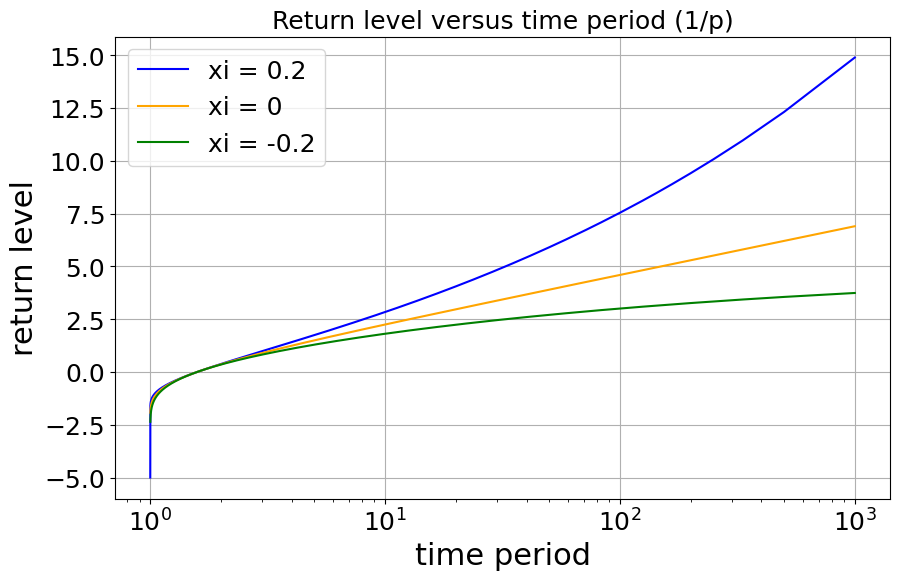

In [76]:

# Parameters
mu = 0
sigma = 1

# Generate points
p = np.linspace(0, 1, 1000)[1:]  # ppoints(1000) without the first point
yp = -np.log(1 - p)

# Calculate zp values
zp_1 = mu - (sigma / 0.2) * (1 - yp ** (-0.2))   # xi = 0.2
zp_2 = mu - sigma * np.log(yp)                    # xi = 0
zp_3 = mu - (sigma / -0.2) * (1 - yp ** (0.2))   # xi = -0.2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(1 / p, zp_1, label='xi = 0.2', color='blue')
plt.plot(1 / p, zp_2, label='xi = 0', color='orange')
plt.plot(1 / p, zp_3, label='xi = -0.2', color='green')

# Log scale and labels
plt.xscale('log')
plt.xlabel('time period')
plt.ylabel('return level')
plt.title('Return level versus time period (1/p)')
#plt.xticks([10**i for i in range(5)], [f'10^{i}' for i in range(5)])
plt.legend()
plt.grid(True)
plt.show()


In [77]:
## because the data is not on an equally spaced yearly interval we need to calculate a scale time factor for return times:
sigl_tscale = 11389./1384.
sigl_tscale

8.229046242774567

In [78]:
## because the data is not on an equally spaced yearly interval we need to calculate a scale time factor for return times:
lin_len = len(mis3_lin_volc_load)
print(lin_len)
lin_tscale = 35000./65
lin_tscale

65


538.4615384615385

In [79]:
def estimate_return_level(quantile, loc, scale, shape):
    level = loc + scale / shape * (1 - (-np.log(quantile)) ** (shape))
    return level

In [80]:
# the scipy shape parameter is the negative of \xi "c" = "-\xi"
print(sigl_shape)
print(lin_shape)

-1.344260778639558
-0.4685136930628534


/tmp/ipykernel_287523/3205516377.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,100000)


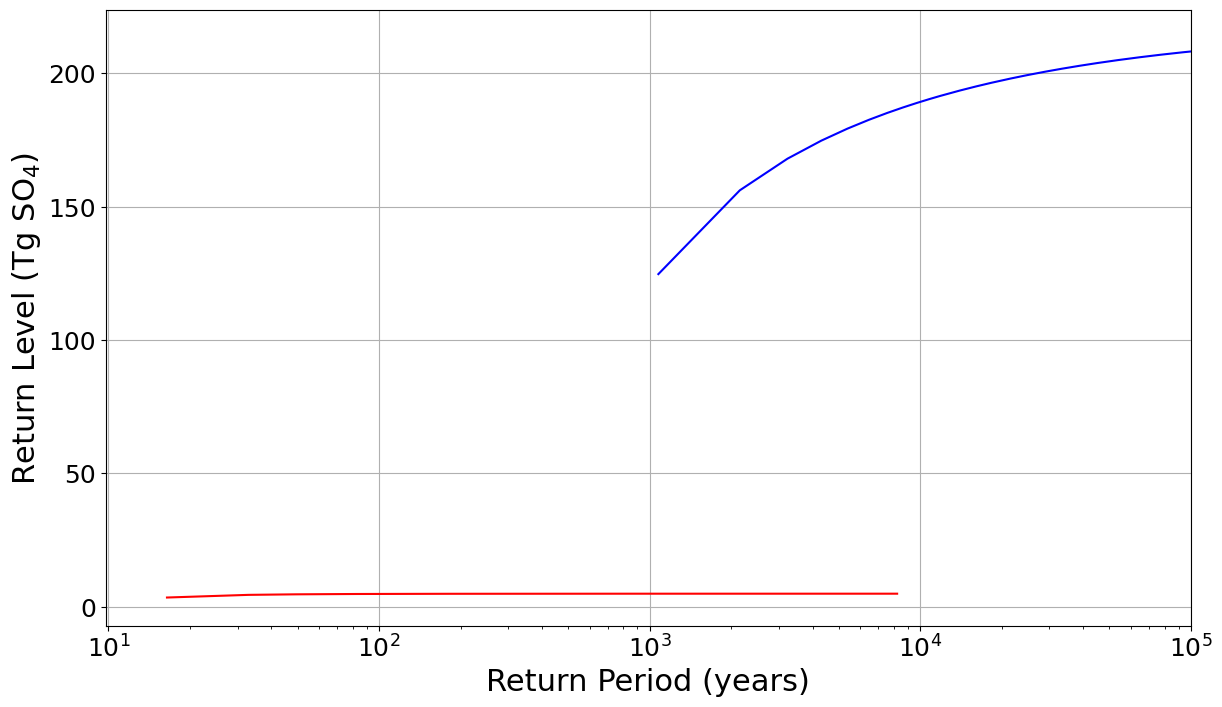

In [81]:
periods = np.arange(2, 1000, 2)
quantiles = 1 - 1 / periods
sigl_levels = estimate_return_level(quantiles, sigl_loc, sigl_scale, -1.0*sigl_shape)
lin_levels = estimate_return_level(quantiles, lin_loc, lin_scale, -1.0*lin_shape)

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(periods*sigl_tscale, sigl_levels, "-", color='red')
ax.plot(periods*lin_tscale, lin_levels, "-", color='blue')
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (Tg SO$_4$)")
ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_ylim(0,600)
ax.set_xlim(0,100000)
ax.grid(True)

In [82]:
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

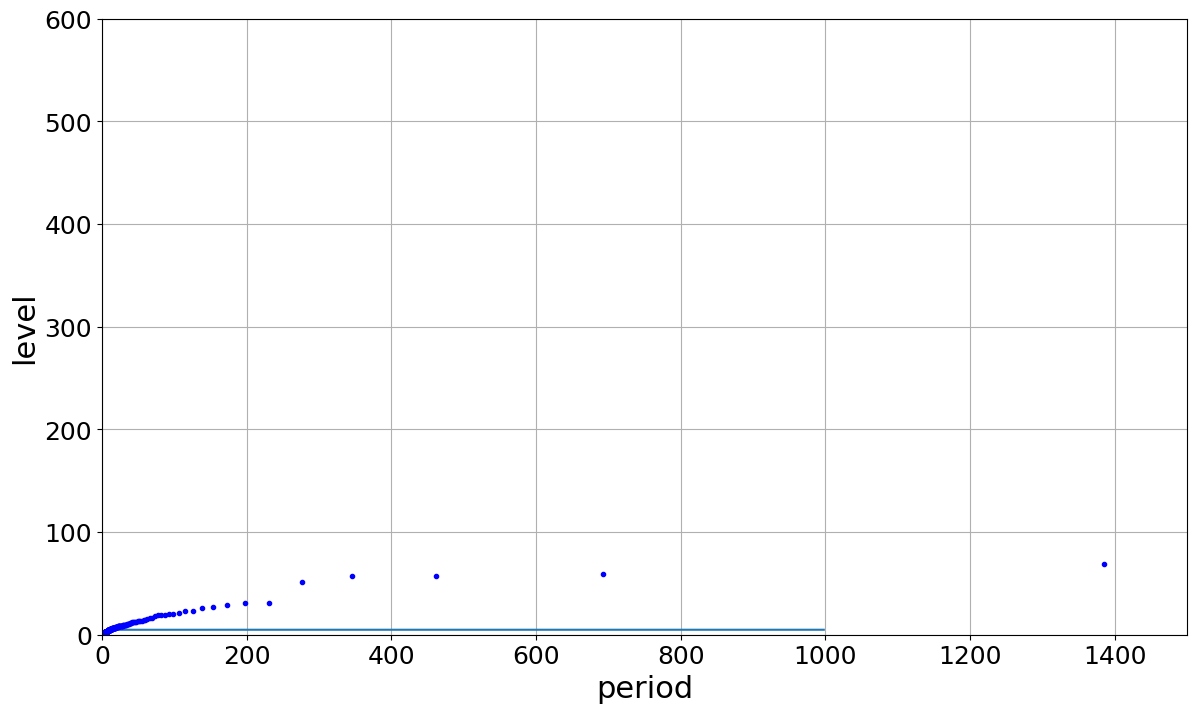

In [83]:
periods = np.arange(2, 1000, 2)
quantiles = 1 - 1 / periods
levels = estimate_return_level(quantiles, loc, scale, -shape)

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(periods, levels, "-")
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (Tg SO$_4$)")
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(0,600)
ax.set_xlim(0,1500)
ax.grid(True)

# get empirical return levels and plot them
# sigl
_ = (empirical_return_level(mass)/sigl_tscale).plot(ax=ax, marker=".", color='blue', linestyle="None")
# lin
#_ = empirical_return_level(volc_load).plot(ax=ax, marker=".", color='red', linestyle="None")


In [84]:
 empirical_return_level(new_contmass)

<xarray.DataArray 'level' (period: 11389)> Size: 91kB
array([0.39, 0.39, 0.42, ...,  nan,  nan,  nan], shape=(11389,))
Coordinates:
  * period   (period) float64 91kB nan nan nan nan nan ... nan nan nan nan nan

[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214 216
 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250 252
 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286 288
 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322 324
 326 328 330 332 334 336 338 340 342 344 346 348 350 352 354 356 358 360
 362 364 366 368 370 372 374 376 378 380 382 384 386 388 390 392 394 396
 398 400 402 404 406 408 410 412 414 416 418 420 422 424 426 428 430 432
 434 436 438 440 442 444 446 448 450 452 454 456 458 460 462 464 466 468
 470 472 474 476 478 480 482 484 486 488 490 492 49

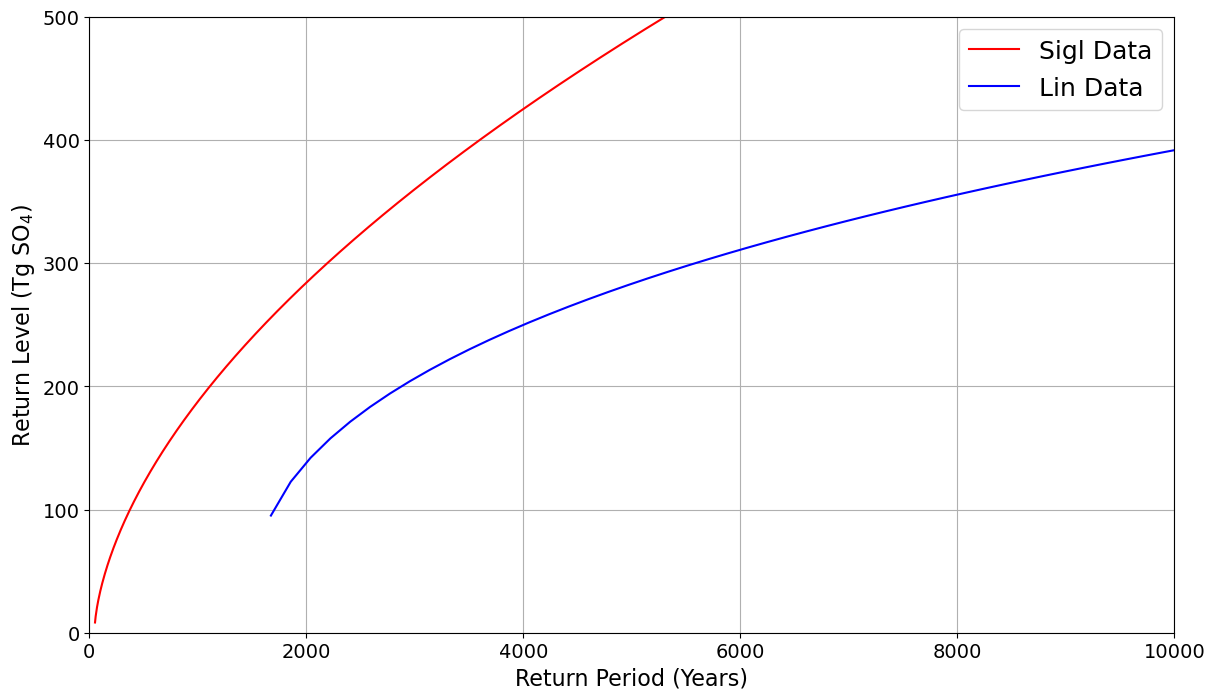

In [85]:
#periods = np.arange(2, 1000, 1)
sigl_periods = np.linspace(1.1, 130, 1000)

lin_periods = np.linspace(1.1, 13, 100)
print(periods)
sigl_quantiles = 1 - 1 / sigl_periods
lin_quantiles = 1 - 1 / lin_periods

sigl_tscale = 47.06 # years in each maximum bin
sigl_levels = estimate_return_level(sigl_quantiles, sigl_ml_loc, sigl_ml_scale, sigl_ml_shape)
#lin_ml_loc
lin_levels = estimate_return_level(lin_quantiles, lin_ml_loc, lin_ml_scale, lin_ml_shape)
lin_tscale = 1520.8 # years in each maximum bin
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(sigl_periods*sigl_tscale, sigl_levels, "-", color='red', label='Sigl Data')
ax.plot(lin_periods*lin_tscale, lin_levels, "-", color='blue', label='Lin Data')
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Return Level (Tg SO$_4$)")
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(0,500)
ax.set_xlim(0,10000)
ax.grid(True)
setaxesfsize(ax,14,"Return Period (Years)","Return Level (Tg SO$_4$)",16)
ax.legend()

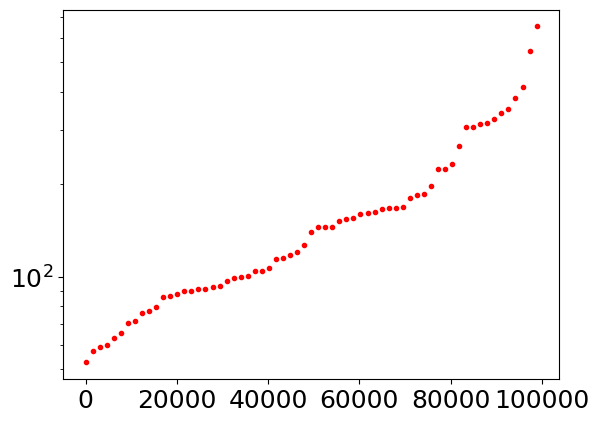

In [86]:
plt.plot(np.linspace(0, len(mis3_lin_volc_load), len(mis3_lin_volc_load))*lin_tscale, empirical_return_level(mis3_lin_volc_load), marker=".", color='red', linestyle="None")
plt.yscale('log')

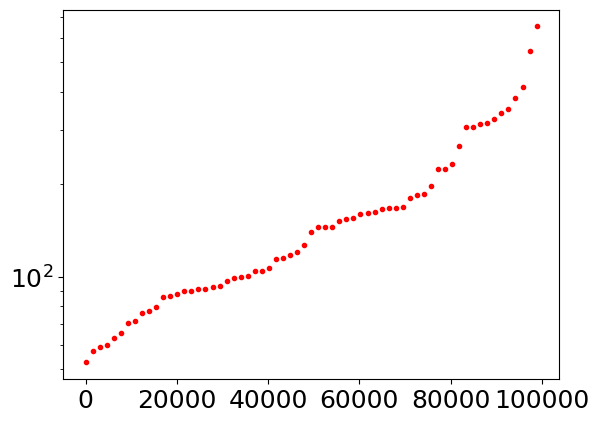

In [87]:
plt.plot(np.linspace(0, len(mis3_lin_volc_load), len(mis3_lin_volc_load))*lin_tscale, empirical_return_level(mis3_lin_volc_load), marker=".", color='red', linestyle="None")
plt.yscale('log')

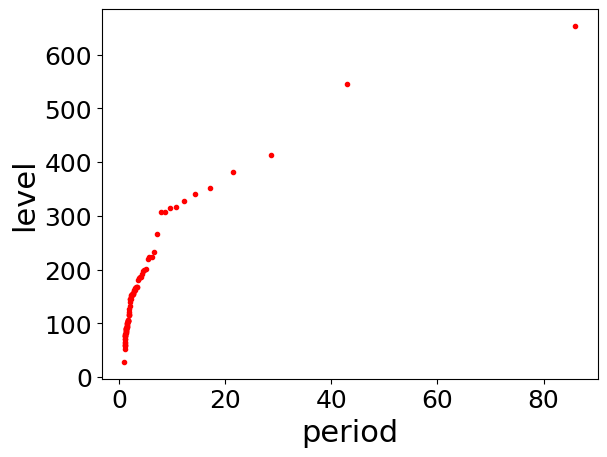

In [88]:
_ = empirical_return_level(volc_load).plot(marker=".", color='red', linestyle="None")


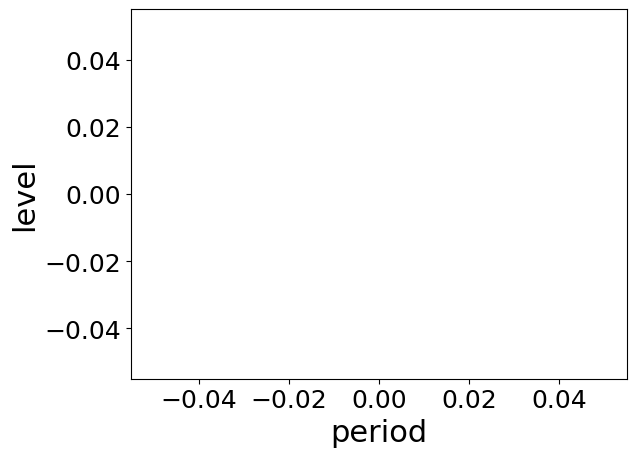

In [89]:
_ = empirical_return_level(new_contmass).plot(marker=".", color='red', linestyle="None")


In [90]:
new_contmass

array([ 8.67,   nan,   nan, ...,   nan,   nan, 13.32], shape=(11389,))

In [91]:
sigl_shape, sigl_loc, sigl_scale = gev.fit(mass)
print(f"Fitted parameters:\nShape: {sigl_shape:.5f}, Location: {sigl_loc:.5f}, Scale: {sigl_scale:.5f}")

Fitted parameters:
Shape: -1.34426, Location: 2.49871, Scale: 3.16342


In [92]:
lin_shape, lin_loc, lin_scale = gev.fit(mis3_lin_volc_load)
print(f"Fitted parameters:\nShape: {lin_shape:.5f}, Location: {lin_loc:.5f}, Scale: {lin_scale:.5f}")

Fitted parameters:
Shape: -0.46851, Location: 107.23891, Scale: 51.76101


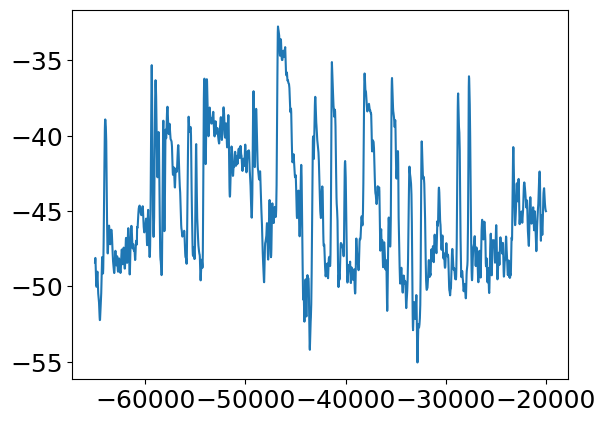

In [93]:
plt.plot(-1.0*ngrip_t_pedro_2018["Year"],ngrip_t_pedro_2018["Temperature"]) 

#### scipy.genextreme uses 1/c = -1/$\xi$ for the shape function(c)
$$
P(x ; \mu, \sigma, \xi) = \frac{1}{\sigma} t(x)^{\xi+1} e^{-t(x)}
$$
where
$$
t(x)= \begin{cases}
\left[1+\xi\left(\frac{x-\mu}{\sigma}\right)\right]^{-1 / \xi} & \text{if } \xi \neq 0 \\
e^{-(x-\mu) / \sigma} & \text { if } \xi=0\end{cases}
$$


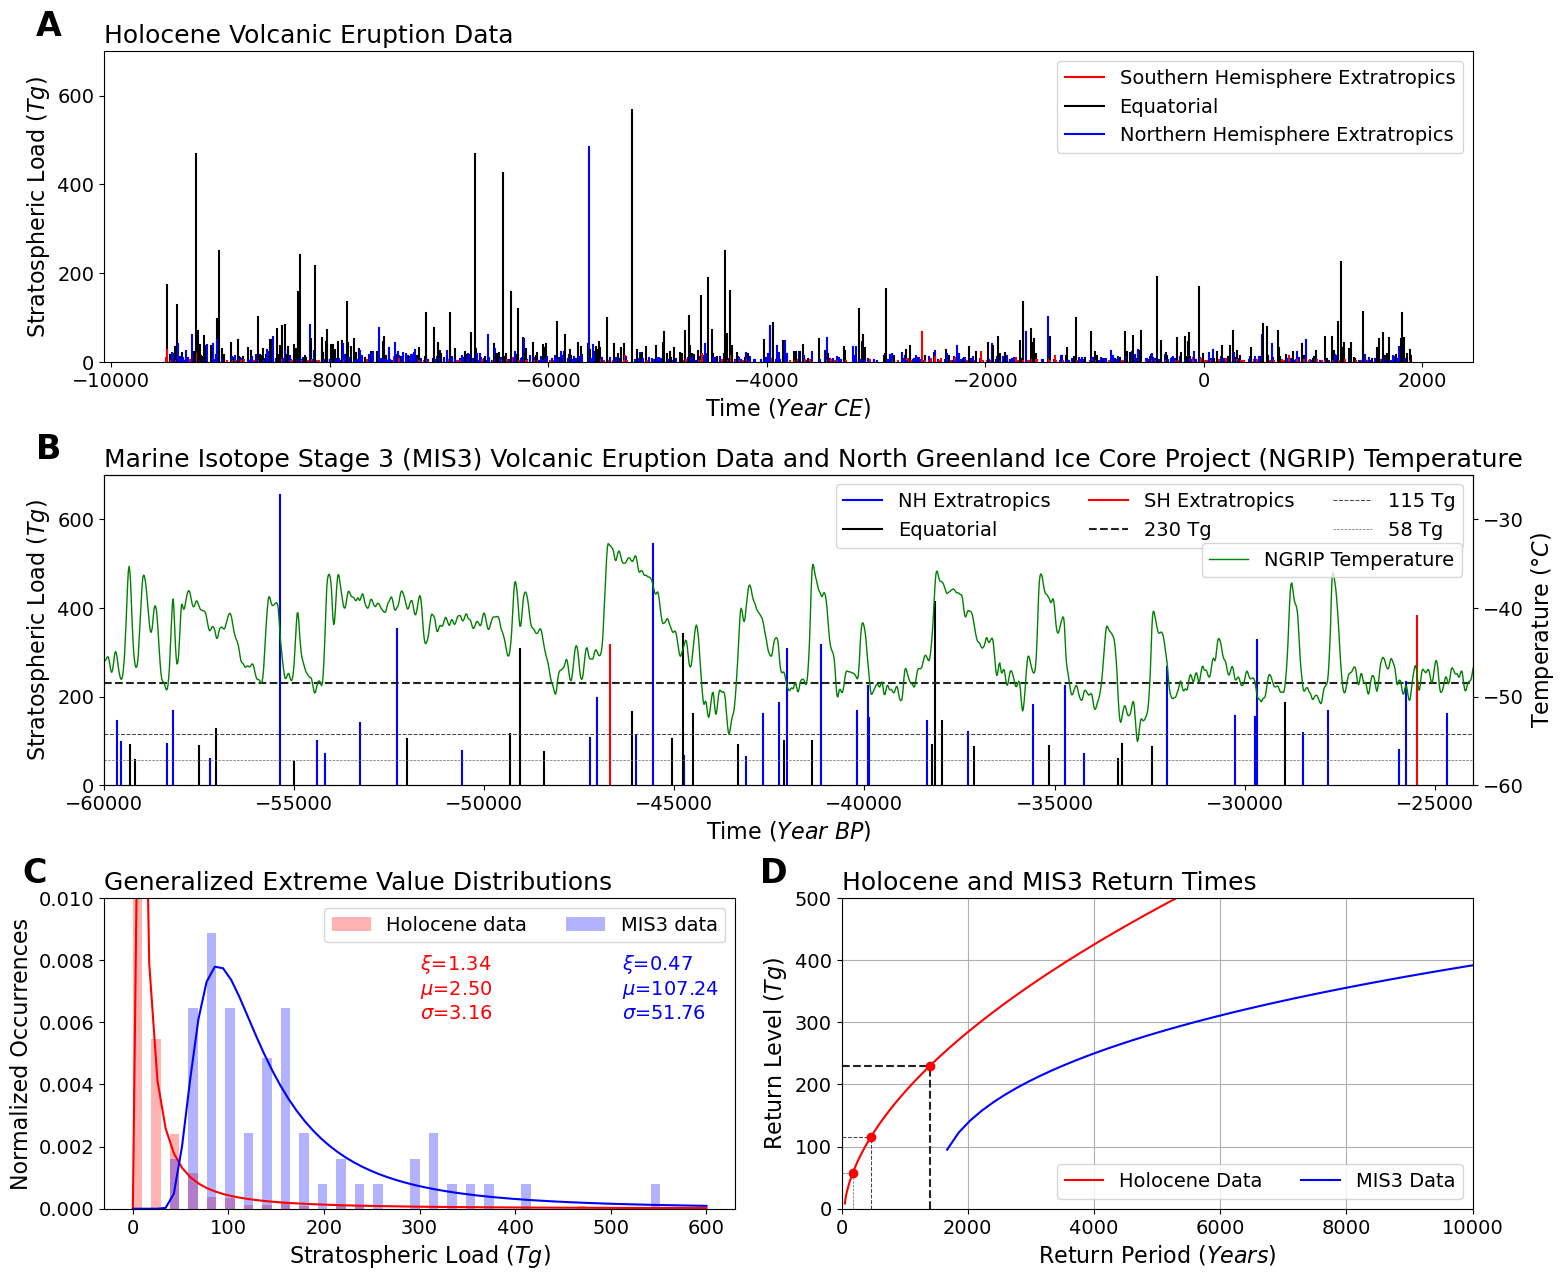

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
#from scipy.stats import gev

# Set up the figure and gridspec
fig = plt.figure(figsize=(16, 13))  # Adjusted size to accommodate all plots
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Common settings
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
###################################################################################################
# First plot (wide)
ax1 = fig.add_subplot(gs[0, :])
t_shift = 2000 - 1892
t_start = -11389 + 1892
eleg, nleg, sleg = True, True, True
for e in range(len(timevar)):
    if new_latitude[e] > 20.0:
        if nleg:
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='b', label="Northern Hemisphere Extratropics")
            nleg=False
        else:
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='b')
    elif new_latitude[e] >= -20 and new_latitude[e] <= 20:
        if eleg:
            eleg=False
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='k', label="Equatorial")
        else:
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='k')
    elif new_latitude[e] < -20.:
        if sleg:
            sleg=False
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='r', label="Southern Hemisphere Extratropics")
        else:
            ax1.plot([t_start + timevar[e], t_start + timevar[e]], [0, new_contmass[e]], color='r')
#ax1.set_ylabel('Load (Tg SO$_4$)')
#ax1.set_xlabel('Time (Year CE)')
ax1.legend(fontsize=14)
ax1.set_title("Holocene Volcanic Eruption Data", loc='left', size=18)
setaxesfsize(ax1,14,r'Time ($Year~CE$)',r'Stratospheric Load ($Tg$)',16)
ax1.set_ylim(0,700)
########################################################################################################
# Second plot (wide)
ax2 = fig.add_subplot(gs[1, :])
eleg, nleg, sleg = True, True, True
for e in range(len(gicc05_age)):
    if site_loc[e] == "NHHL":
        if nleg:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='b', label="NH Extratropics")
            nleg=False
        else:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='b')
    elif site_loc[e] == "LL or SH":
        if eleg:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='k', label="Equatorial")
            eleg=False
        else:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='k')
    elif site_loc[e] == "SH":
        if sleg:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='r', label="SH Extratropics")
            sleg=False
        else:
            ax2.plot([-gicc05_age[e],-gicc05_age[e]],[0,volc_load[e]],color='r')
#ax2.set_ylabel("Load (Tg SO$_4$)")
#ax2.set_xlabel('Time (Year BP)')
ax2.set_ylim(0,700)
ax2.set_xlim(-60000,-24000)
ax2.legend(fontsize=14, ncol=3)
ax2.set_title("Marine Isotope Stage 3 (MIS3) Volcanic Eruption Data and North Greenland Ice Core Project (NGRIP) Temperature", loc='left', size=18)
setaxesfsize(ax2,14,r'Time ($Year~BP$)',r'Stratospheric Load ($Tg$)', 16)

# add in NGRIP temperature data
ax2r = ax2.twinx()
ax2r.plot(-1.0*ngrip_t_pedro_2018["Year"],ngrip_t_pedro_2018["Temperature"], color='green', linewidth=1.0, label='NGRIP Temperature')
setaxesfsize(ax2r,14,'',r'Temperature ($\degree C$)', 16)
ax2r.set_ylim(-60,-25)
ax2r.legend(fontsize=14, ncol=1, loc=(0.802,0.67))

## In this subplot we will add horizontal lines at 230, 116, 60 Tg SO4 to show the simulated levels
simlw = 0.5
ax2.axhline(y=230, color='#222222', linestyle='--', label='230 Tg', linewidth=simlw*3)
ax2.axhline(y=116, color='#444444', linestyle='--', label='115 Tg', linewidth=simlw*1.5)
ax2.axhline(y=58, color='#666666', linestyle='--', label='58 Tg', linewidth=simlw)
ax2.legend(fontsize=14, ncol=3)

###################################################################################################
# Third plot (square)
ax3 = fig.add_subplot(gs[2, 0])
hist_sigl, bins_sigl = np.histogram(mass, bins=31, range=(0, 600), density=True)
ax3.bar(bins_sigl[:-1], hist_sigl, width=10, align='edge', alpha=0.3, color='red', label="Holocene data")
hist_lin, bins_lin = np.histogram(mis3_lin_volc_load, bins=31, range=(0, 600), density=True)
ax3.bar(bins_lin[:-1], hist_lin, width=10, align='edge', alpha=0.3, color='blue', label="MIS3 data")
ax3.set_ylabel("Normalized Occurrences")
ax3.set_xlabel(r"Stratospheric Load ($Tg$)", size=16)
setaxesfsize(ax3, 14, r"Stratospheric Load ($Tg$)", "Normalized Occurrences", 16)
ax3.set_ylim(0, 0.01)
ax3.legend(fontsize=14, ncol=2)

sigl_l = sigl_loc + sigl_scale / sigl_shape
sigl_xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
sigl_yy = gev.pdf(sigl_xx, sigl_shape, sigl_loc, sigl_scale)
ax3.plot(sigl_xx, sigl_yy, 'red', linewidth = 1.5, label = "Sigl GEV fit")

lin_l = lin_loc + lin_scale / lin_shape
lin_xx = np.linspace(l+0.00001, l+0.00001+600, num=71)
lin_yy = gev.pdf(lin_xx, lin_shape, lin_loc, lin_scale)
ax3.plot(lin_xx, lin_yy, 'blue', linewidth = 1.5, label = "Lin GEV fit")

ax3.set_title("Generalized Extreme Value Distributions", loc='left', size=18)

# Add text box with parameters
sigl_params = sigl_shape, sigl_loc, sigl_scale
lin_params = lin_shape, lin_loc, lin_scale
bbox = dict(boxstyle="round", color="white", linewidth=2)
## scipy uses 1/c instead of -1/xi , so we have to multiply by -1
ax3.text(0.5, 0.61, r'$\xi$=%.2f' '\n' r'$\mu$=%.2f' '\n' r'$\sigma$=%.2f' % (-1.0*sigl_params[0], sigl_params[1], sigl_params[2]),
         transform=ax3.transAxes, bbox=bbox, color='red', size=14)
ax3.text(0.82, 0.61, r'$\xi$=%.2f' '\n' r'$\mu$=%.2f' '\n' r'$\sigma$=%.2f' % (-1.0*lin_params[0], lin_params[1], lin_params[2]),
         transform=ax3.transAxes, bbox=bbox, color='blue', size=14)
###############################################################################################################################

# Fourth plot (square)
ax4 = fig.add_subplot(gs[2, 1])
#periods = np.arange(2, 1000, 1)
#quantiles = 1 - 1 / periods
#sigl_levels = estimate_return_level(quantiles, sigl_loc, sigl_scale, sigl_shape)
#lin_levels = estimate_return_level(quantiles, lin_loc, lin_scale, lin_shape)
ax4.plot(sigl_periods*sigl_tscale, sigl_levels, "-", color='red', label='Holocene Data')
ax4.plot(lin_periods*lin_tscale, lin_levels, "-", color='blue', label='MIS3 Data')
ax4.set_xlabel("Return Period (years)")
ax4.set_ylabel("Return Level (Tg)")
ax4.set_ylim(0,500)
ax4.set_xlim(0,10000)
ax4.grid(True)
setaxesfsize(ax4,14,r"Return Period ($Years$)",r"Return Level ($Tg$)",16)
ax4.set_title("Holocene and MIS3 Return Times", loc='left', size=18)
ax4.legend(fontsize=14, ncol=2)
# Adjust the layout
plt.tight_layout()

## Add a horizontal line going from 230, 116, 60 Tg SO4 on the y-axis to the y value on the red curve 
## Add a vertical line going from 0 on the x-axis to y value on the red curve at 230, 116, 60 Tg SO4 on the y-axis
## I need it to stop when the lines intercept the red curve

# Find the x-values where the horizontal lines intersect the red curve
x_230 = np.interp(230, sigl_levels, sigl_periods*sigl_tscale)
x_116 = np.interp(116, sigl_levels, sigl_periods*sigl_tscale)
x_58 = np.interp(58, sigl_levels, sigl_periods*sigl_tscale)

# Horizontal lines
ax4.plot([0, x_230], [230, 230], color='#222222', linestyle='--', linewidth=simlw*3)
ax4.plot([0, x_116], [116, 116], color='#444444', linestyle='--', linewidth=simlw*1.5)
ax4.plot([0, x_58], [58, 58], color='#666666', linestyle='--', linewidth=simlw)

# Vertical lines
ax4.plot([x_230, x_230], [0, 230], color='#222222', linestyle='--', linewidth=simlw*3)
ax4.plot([x_116, x_116], [0, 116], color='#444444', linestyle='--', linewidth=simlw*1.5)
ax4.plot([x_58, x_58], [0, 58], color='#666666', linestyle='--', linewidth=simlw)

# Add intersection points
ax4.plot(x_230, 230, 'ro')
ax4.plot(x_116, 116, 'ro')
ax4.plot(x_58, 58, 'ro')


# add a,b,c,d
lfsize = 24
ax1.text(-0.05, 1.05, 'A',
         transform=ax1.transAxes, size=lfsize, weight='bold')
ax2.text(-0.05, 1.05, 'B',
         transform=ax2.transAxes, size=lfsize, weight='bold')
ax3.text(-0.13, 1.05, 'C',
         transform=ax3.transAxes, size=lfsize, weight='bold')
ax4.text(-0.13, 1.05, 'D',
         transform=ax4.transAxes, size=lfsize, weight='bold')

# Save the plot

icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure1.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure1.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
